# Stage 2.2 — EDA distributions and segmented patterns (Blocks D + segmented bridge)


In [1]:
from __future__ import annotations

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from garmin_analytics.eda import add_derived_features, build_eda_frames, load_daily_sanitized, load_quality
from garmin_analytics.eda.plots_common import maybe_savefig, repo_root

In [ ]:
SAVE_FIGS: bool = False
DPI: int = 150
FIG_FMT: str = 'png'

ROOT = repo_root(Path.cwd())
DAILY_PATH = ROOT / 'data/processed/daily_sanitized.parquet'
QUALITY_PATH = ROOT / 'data/processed/daily_quality.parquet'
SUSPICIOUS_PATH = ROOT / 'reports/suspicious_days.csv'
SUSPICIOUS_ARTIFACTS_PATH = ROOT / 'reports/suspicious_days_artifacts.csv'
FIG_DIR = ROOT / 'reports/figures/distributions'

print('Repo root:', ROOT)
print('Daily input:', DAILY_PATH)
print('Quality input:', QUALITY_PATH)
print('Suspicious input:', SUSPICIOUS_PATH)
print('Suspicious artifacts input:', SUSPICIOUS_ARTIFACTS_PATH)


Repo root: /Users/abatrakov/Documents/FUN/wearable-analytics
Daily input: /Users/abatrakov/Documents/FUN/wearable-analytics/data/processed/daily_sanitized.parquet
Quality input: /Users/abatrakov/Documents/FUN/wearable-analytics/data/processed/daily_quality.parquet
Suspicious input: /Users/abatrakov/Documents/FUN/wearable-analytics/reports/suspicious_days.csv
Suspicious artifacts input: /Users/abatrakov/Documents/FUN/wearable-analytics/reports/suspicious_days_artifacts.csv


In [3]:
daily_df = load_daily_sanitized(DAILY_PATH)
quality_df = load_quality(QUALITY_PATH)
frames = build_eda_frames(daily_df, quality_df)


def _sanitize_stress_level_range_base(frame: pd.DataFrame, *, lo: float = 0.0, hi: float = 100.0) -> pd.DataFrame:
    """Notebook-global cleanup for stress-level sentinels (e.g., -2)."""
    out = frame.copy()
    for col in out.columns:
        if ('averageStressLevel' in str(col)) or ('avgSleepStress' in str(col)):
            s = pd.to_numeric(out[col], errors='coerce')
            out[col] = s.where((s >= lo) & (s <= hi))
    return out


df_all = _sanitize_stress_level_range_base(add_derived_features(frames['df_all']))
df_strict = _sanitize_stress_level_range_base(add_derived_features(frames['df_strict']))
df_sleep = _sanitize_stress_level_range_base(add_derived_features(frames['df_sleep']))

suspicious_days = pd.read_csv(SUSPICIOUS_PATH) if SUSPICIOUS_PATH.exists() else pd.DataFrame()
suspicious_days_artifacts = pd.read_csv(SUSPICIOUS_ARTIFACTS_PATH) if SUSPICIOUS_ARTIFACTS_PATH.exists() else pd.DataFrame()

pd.DataFrame([
    {'slice': 'df_all', 'rows': len(df_all), 'date_min': pd.to_datetime(df_all['calendarDate']).min(), 'date_max': pd.to_datetime(df_all['calendarDate']).max()},
    {'slice': 'df_strict', 'rows': len(df_strict), 'date_min': pd.to_datetime(df_strict['calendarDate']).min(), 'date_max': pd.to_datetime(df_strict['calendarDate']).max()},
    {'slice': 'df_sleep', 'rows': len(df_sleep), 'date_min': pd.to_datetime(df_sleep['calendarDate']).min(), 'date_max': pd.to_datetime(df_sleep['calendarDate']).max()},
])



,slice,rows,date_min,date_max
0,df_all,580,2023-05-26,2026-02-05
1,df_strict,525,2023-05-26,2026-02-05
2,df_sleep,474,2023-05-27,2026-02-05


## 1. Curated metric roster (analysis matrix)

Question: **Which metrics are in scope here, and why?**

This locks a curated metric set before relationship and artifact sections grow.


In [4]:
def _sleep_score_bucket_garmin(score):
    if pd.isna(score):
        return 'unknown'
    score = float(score)
    if score < 60:
        return 'poor'
    if score < 80:
        return 'fair'
    if score < 90:
        return 'good'
    return 'excellent'


def _ensure_step_length(frame: pd.DataFrame, *, min_steps: int = 1000) -> pd.DataFrame:
    out = frame.copy()
    if {'totalSteps', 'totalDistanceMeters'}.issubset(out.columns):
        steps = pd.to_numeric(out['totalSteps'], errors='coerce')
        dist = pd.to_numeric(out['totalDistanceMeters'], errors='coerce')
        out['step_length_m'] = np.where(steps >= min_steps, dist / steps, np.nan)
    return out


def _ensure_activity_duration_hours(frame: pd.DataFrame) -> pd.DataFrame:
    out = frame.copy()
    if 'activeSeconds' in out.columns and 'active_hours' not in out.columns:
        out['active_hours'] = pd.to_numeric(out['activeSeconds'], errors='coerce') / 3600.0
    if 'highlyActiveSeconds' in out.columns:
        out['highly_active_hours'] = pd.to_numeric(out['highlyActiveSeconds'], errors='coerce') / 3600.0
    return out


def _ensure_bb_net(frame: pd.DataFrame) -> pd.DataFrame:
    out = frame.copy()
    charged_cols = [c for c in ['bodyBattery_chargedValue', 'bodyBatteryChargedValue'] if c in out.columns]
    drained_cols = [c for c in ['bodyBattery_drainedValue', 'bodyBatteryDrainedValue'] if c in out.columns]
    if charged_cols and drained_cols:
        out['bb_net_balance'] = (
            pd.to_numeric(out[charged_cols[0]], errors='coerce')
            - pd.to_numeric(out[drained_cols[0]], errors='coerce')
        )
    return out


df_strict_d = _ensure_bb_net(_ensure_activity_duration_hours(_ensure_step_length(df_strict, min_steps=1000)))
df_sleep_d = _ensure_bb_net(_ensure_activity_duration_hours(_ensure_step_length(df_sleep, min_steps=1000)))
if 'sleepOverallScore' in df_sleep_d.columns:
    df_sleep_d['sleep_quality_bucket_garmin'] = pd.to_numeric(df_sleep_d['sleepOverallScore'], errors='coerce').apply(_sleep_score_bucket_garmin)

metric_roster = pd.DataFrame([
    {'group': 'activity', 'metric': 'totalSteps', 'slice': 'df_strict', 'role': 'distribution+relationship', 'priority': 'core'},
    {'group': 'activity', 'metric': 'step_length_m', 'slice': 'df_strict_d', 'role': 'distribution+relationship', 'priority': 'core'},
    {'group': 'activity', 'metric': 'active_hours', 'slice': 'df_strict_d', 'role': 'distribution+relationship', 'priority': 'core'},
    {'group': 'activity', 'metric': 'highly_active_hours', 'slice': 'df_strict_d', 'role': 'distribution+relationship', 'priority': 'core'},
    {'group': 'activity', 'metric': 'floorsAscendedInMeters', 'slice': 'df_strict', 'role': 'distribution', 'priority': 'supporting'},
    {'group': 'stress', 'metric': 'allDayStress_TOTAL_averageStressLevel', 'slice': 'df_strict', 'role': 'distribution+relationship', 'priority': 'core'},
    {'group': 'stress', 'metric': 'allDayStress_AWAKE_averageStressLevel', 'slice': 'df_strict', 'role': 'distribution+relationship', 'priority': 'core'},
    {'group': 'stress', 'metric': 'allDayStress_ASLEEP_averageStressLevel', 'slice': 'df_sleep', 'role': 'distribution+relationship', 'priority': 'core'},
    {'group': 'stress', 'metric': 'stress_hours', 'slice': 'df_strict', 'role': 'distribution+artifact-diagnostic', 'priority': 'supporting'},
    {'group': 'heart', 'metric': 'restingHeartRate', 'slice': 'df_strict', 'role': 'distribution+relationship', 'priority': 'core'},
    {'group': 'heart', 'metric': 'minHeartRate', 'slice': 'df_strict', 'role': 'distribution', 'priority': 'supporting'},
    {'group': 'heart', 'metric': 'maxHeartRate', 'slice': 'df_strict', 'role': 'distribution', 'priority': 'supporting'},
    {'group': 'body_battery', 'metric': 'bodyBatteryHighest', 'slice': 'df_strict', 'role': 'distribution+relationship', 'priority': 'core'},
    {'group': 'body_battery', 'metric': 'bodyBatteryLowest', 'slice': 'df_strict', 'role': 'distribution+relationship', 'priority': 'core'},
    {'group': 'body_battery', 'metric': 'bodyBattery_chargedValue', 'slice': 'df_strict', 'role': 'distribution+relationship', 'priority': 'core'},
    {'group': 'body_battery', 'metric': 'bodyBattery_drainedValue', 'slice': 'df_strict', 'role': 'distribution+relationship', 'priority': 'core'},
    {'group': 'body_battery', 'metric': 'bb_net_balance', 'slice': 'df_strict_d', 'role': 'distribution+relationship', 'priority': 'core'},
    {'group': 'sleep', 'metric': 'sleep_total_hours', 'slice': 'df_sleep_d', 'role': 'distribution+relationship', 'priority': 'core'},
    {'group': 'sleep', 'metric': 'sleepOverallScore', 'slice': 'df_sleep', 'role': 'distribution+relationship', 'priority': 'core'},
    {'group': 'sleep', 'metric': 'sleepQualityScore', 'slice': 'df_sleep', 'role': 'distribution', 'priority': 'supporting'},
    {'group': 'sleep', 'metric': 'sleepDurationScore', 'slice': 'df_sleep', 'role': 'distribution', 'priority': 'supporting'},
    {'group': 'sleep', 'metric': 'sleepRecoveryScore', 'slice': 'df_sleep', 'role': 'distribution+relationship', 'priority': 'core'},
    {'group': 'sleep', 'metric': 'avgSleepStress', 'slice': 'df_sleep', 'role': 'distribution+relationship', 'priority': 'core'},
    {'group': 'sleep', 'metric': 'averageRespiration', 'slice': 'df_sleep', 'role': 'distribution', 'priority': 'supporting'},
    {'group': 'sleep', 'metric': 'lowestRespiration', 'slice': 'df_sleep', 'role': 'distribution', 'priority': 'supporting'},
    {'group': 'sleep', 'metric': 'highestRespiration', 'slice': 'df_sleep', 'role': 'distribution', 'priority': 'supporting'},
    {'group': 'sleep', 'metric': 'averageSpo2Value / lowestSpo2Value', 'slice': 'df_sleep', 'role': 'distribution+relationship', 'priority': 'supporting'},
    {'group': 'artifact_diagnostic', 'metric': 'stressTotalDurationSeconds', 'slice': 'df_all', 'role': 'artifact-diagnostic', 'priority': 'core'},
    {'group': 'artifact_diagnostic', 'metric': 'durationInMilliseconds', 'slice': 'df_all', 'role': 'artifact-diagnostic', 'priority': 'core'},
    {'group': 'artifact_diagnostic', 'metric': 'has_* flags + corrupted_stress_only_day', 'slice': 'df_all', 'role': 'artifact-diagnostic', 'priority': 'core'},
])

metric_roster


,group,metric,slice,role,priority
0,activity,totalSteps,df_strict,distribution+relationship,core
1,activity,step_length_m,df_strict_d,distribution+relationship,core
2,activity,active_hours,df_strict_d,distribution+relationship,core
3,activity,highly_active_hours,df_strict_d,distribution+relationship,core
4,activity,floorsAscendedInMeters,df_strict,distribution,supporting
5,stress,allDayStress_TOTAL_averageStressLevel,df_strict,distribution+relationship,core
6,stress,allDayStress_AWAKE_averageStressLevel,df_strict,distribution+relationship,core
7,stress,allDayStress_ASLEEP_averageStressLevel,df_sleep,distribution+relationship,core
8,stress,stress_hours,df_strict,distribution+artifact-diagnostic,supporting
9,heart,restingHeartRate,df_strict,distribution+relationship,core


### Roster notes

- `df_strict_d` / `df_sleep_d` are convenience copies with derived fields used in this notebook (`step_length_m`, `bb_net_balance`, Garmin sleep buckets).
- `totalDistanceMeters` is intentionally omitted as a core metric because it largely duplicates `totalSteps` in this Stage 2 context.
- Artifact diagnostics remain in scope for Block F but are not treated as outcome metrics.
- Stress-level sentinels/out-of-range values (`<0` or `>100`) are sanitized to `NaN` globally at frame build time.



In [5]:
availability_rows = []
frame_map = {'df_all': df_all, 'df_strict': df_strict, 'df_sleep': df_sleep, 'df_strict_d': df_strict_d, 'df_sleep_d': df_sleep_d}
for _, row in metric_roster.iterrows():
    metric = row['metric']
    frame = frame_map.get(row['slice'])
    present = False
    non_null_count = np.nan
    if frame is not None and ' / ' not in metric and metric in frame.columns:
        present = True
        non_null_count = int(frame[metric].notna().sum())
    elif frame is not None and metric == 'averageSpo2Value / lowestSpo2Value':
        present = (any(c in frame.columns for c in ['averageSpo2Value', 'spo2SleepAverageSPO2'])
                   and any(c in frame.columns for c in ['lowestSpo2Value', 'spo2SleepLowestSPO2']))
    elif frame is not None and metric == 'has_* flags + corrupted_stress_only_day':
        present = ('corrupted_stress_only_day' in frame.columns and any(c in frame.columns for c in ['has_sleep', 'has_hr', 'has_steps', 'has_bodybattery_end']))
    availability_rows.append({**row.to_dict(), 'present': bool(present), 'non_null_count': non_null_count})

pd.DataFrame(availability_rows)


,group,metric,slice,role,priority,present,non_null_count
0,activity,totalSteps,df_strict,distribution+relationship,core,True,525.0
1,activity,step_length_m,df_strict_d,distribution+relationship,core,True,463.0
2,activity,active_hours,df_strict_d,distribution+relationship,core,True,525.0
3,activity,highly_active_hours,df_strict_d,distribution+relationship,core,True,525.0
4,activity,floorsAscendedInMeters,df_strict,distribution,supporting,True,525.0
5,stress,allDayStress_TOTAL_averageStressLevel,df_strict,distribution+relationship,core,True,525.0
6,stress,allDayStress_AWAKE_averageStressLevel,df_strict,distribution+relationship,core,True,525.0
7,stress,allDayStress_ASLEEP_averageStressLevel,df_sleep,distribution+relationship,core,True,460.0
8,stress,stress_hours,df_strict,distribution+artifact-diagnostic,supporting,True,525.0
9,heart,restingHeartRate,df_strict,distribution+relationship,core,True,524.0


## 2. Block D — Distributions and variability

Question: **What does a typical day look like for key metrics, and what do the tails / outliers look like?**

This first pass focuses on curated univariate distributions by metric family.


In [6]:
def plot_distribution(
    frame: pd.DataFrame,
    col: str,
    *,
    title: str,
    bins: int = 30,
    fig_name: str | None = None,
    clip_upper_q: float | None = None,
    integer_bins: bool = False,
    add_ecdf: bool = False,
    bin_edges: np.ndarray | list[float] | None = None,
):
    if col not in frame.columns:
        print(f'Skip: missing column {col}')
        return

    series = pd.to_numeric(frame[col], errors='coerce').dropna()
    if series.empty:
        print(f'Skip: no numeric data for {col}')
        return

    clipped = series.copy()
    clip_note = None
    if clip_upper_q is not None and 0 < clip_upper_q < 1 and len(series) >= 10:
        qv = float(series.quantile(clip_upper_q))
        if np.isfinite(qv):
            clipped = series.clip(upper=qv)
            if float(series.max()) > qv:
                clip_note = f'clip p{int(round(clip_upper_q*100))}'

    width_ratios = [4, 1, 2] if add_ecdf else [4, 1]
    fig, axes = plt.subplots(1, len(width_ratios), figsize=(14 if add_ecdf else 12, 4), gridspec_kw={'width_ratios': width_ratios})
    if add_ecdf:
        ax_hist, ax_box, ax_ecdf = axes
    else:
        ax_hist, ax_box = axes
        ax_ecdf = None

    hist_kwargs = {'alpha': 0.85}
    if bin_edges is not None:
        hist_kwargs['bins'] = np.asarray(bin_edges, dtype='float64')
    elif integer_bins and clipped.notna().any():
        lo = int(np.floor(clipped.min()))
        hi = int(np.ceil(clipped.max()))
        if hi >= lo and (hi - lo) <= 200:
            hist_kwargs['bins'] = np.arange(lo - 0.5, hi + 1.5, 1.0)
        else:
            hist_kwargs['bins'] = bins
    else:
        hist_kwargs['bins'] = bins

    ax_hist.hist(clipped.values, **hist_kwargs)
    ax_hist.axvline(series.median(), linestyle='--', linewidth=1.5, label='median')
    ax_hist.axvline(series.quantile(0.05), linestyle=':', linewidth=1.0, label='p05')
    ax_hist.axvline(series.quantile(0.95), linestyle=':', linewidth=1.0, label='p95')
    ax_hist.set_title(title)
    ax_hist.set_xlabel(col)
    ax_hist.set_ylabel('count')
    if clip_note:
        ax_hist.text(0.01, 0.98, clip_note, transform=ax_hist.transAxes, ha='left', va='top', fontsize=8, color='#555555')
    ax_hist.legend(loc='best')

    ax_box.boxplot(series.values, vert=True)
    ax_box.set_title('box')
    ax_box.set_xticks([])

    if ax_ecdf is not None:
        x = np.sort(series.values)
        y = np.arange(1, len(x) + 1) / len(x)
        ax_ecdf.plot(x, y, color='#1f77b4', lw=1.6)
        ax_ecdf.set_title('ECDF')
        ax_ecdf.set_xlabel(col)
        ax_ecdf.set_ylabel('F(x)')
        ax_ecdf.grid(alpha=0.2)

    fig.tight_layout()
    if fig_name is not None:
        maybe_savefig(fig, fig_name, save_figs=SAVE_FIGS, fig_dir=FIG_DIR, dpi=DPI, fmt=FIG_FMT)
    plt.show()
    plt.close(fig)


### 2.1 Activity distributions (`df_strict`, `df_strict_d`)


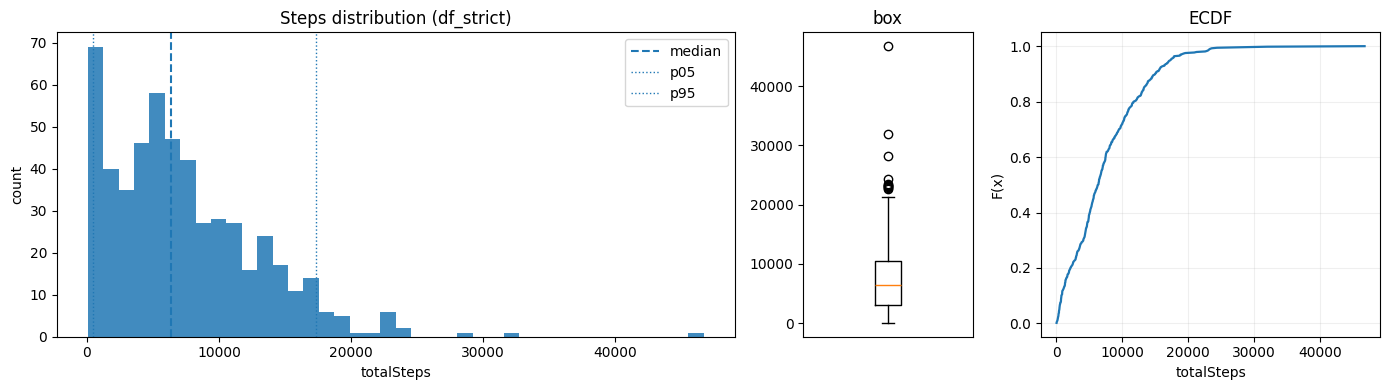

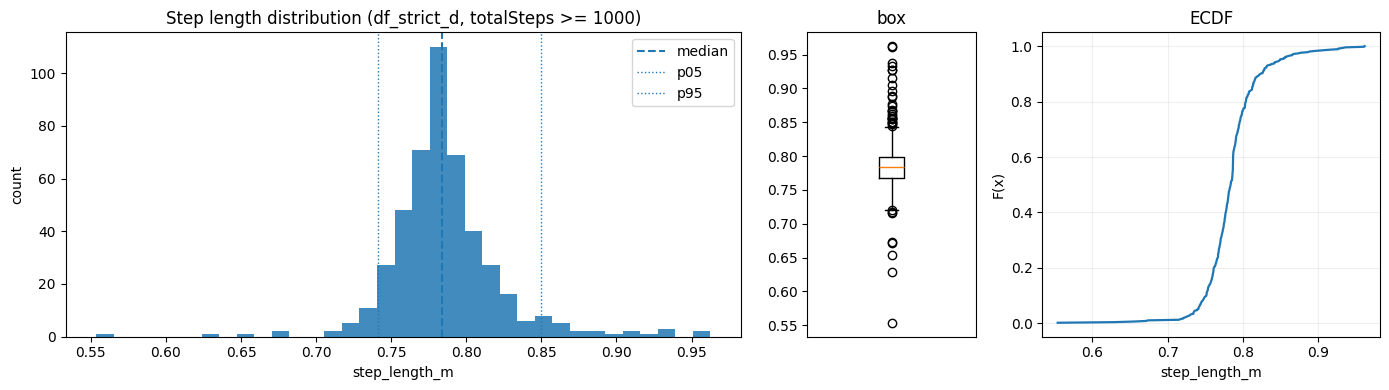

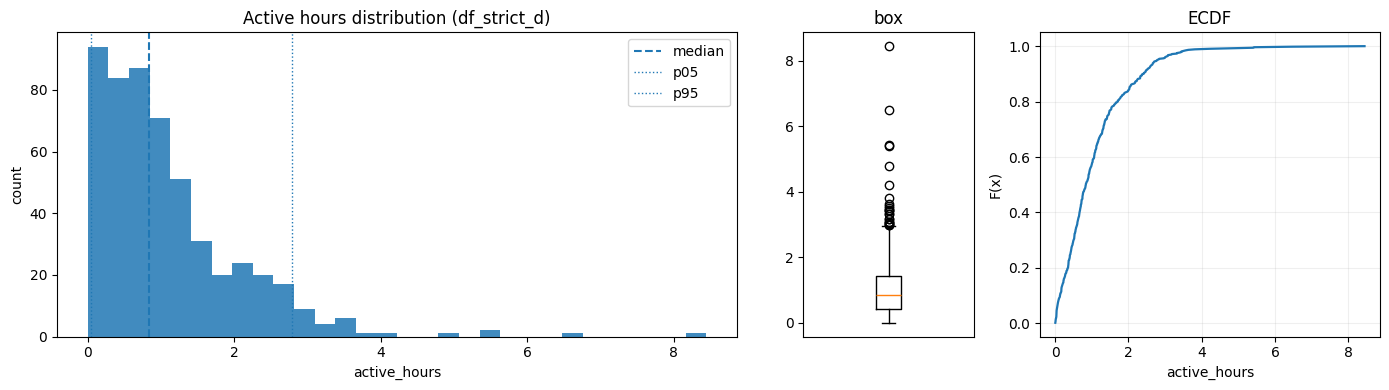

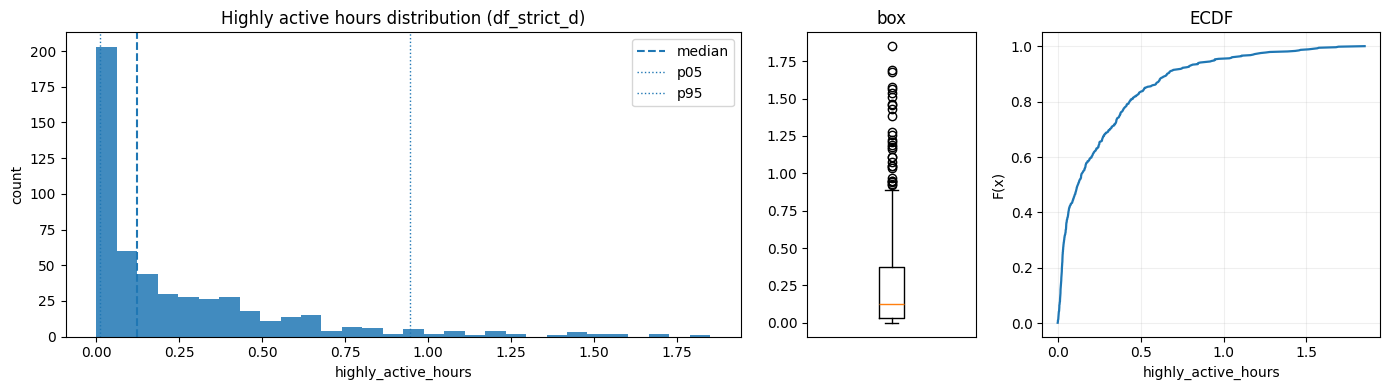

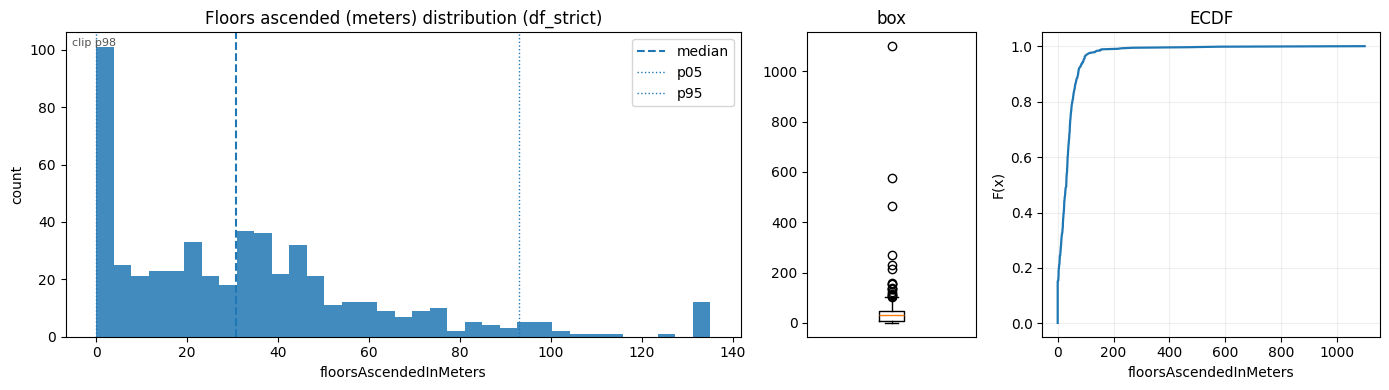

In [7]:
# Activity core distributions (hours-based duration metrics preferred over raw seconds).
activity_metrics = [
    ('totalSteps', 'Steps distribution (df_strict)', 40, 'dist_steps_strict', df_strict, False, None, True),
    ('step_length_m', 'Step length distribution (df_strict_d, totalSteps >= 1000)', 35, 'dist_step_length_strict_steps_ge_1000', df_strict_d, False, None, True),
    ('active_hours', 'Active hours distribution (df_strict_d)', 30, 'dist_active_hours_strict', df_strict_d, False, None, True),
    ('highly_active_hours', 'Highly active hours distribution (df_strict_d)', 30, 'dist_highly_active_hours_strict', df_strict_d, False, None, True),
]

for col, title, bins, fig_name, frame, integer_bins, clip_upper_q, add_ecdf in activity_metrics:
    plot_distribution(
        frame,
        col,
        title=title,
        bins=bins,
        fig_name=fig_name,
        integer_bins=integer_bins,
        clip_upper_q=clip_upper_q,
        add_ecdf=add_ecdf,
    )

# Supporting: floors have real outliers (e.g., mountain days), so clip histogram for readability and add ECDF.
plot_distribution(
    df_strict,
    'floorsAscendedInMeters',
    title='Floors ascended (meters) distribution (df_strict)',
    bins=35,
    fig_name='dist_floors_ascended_m_strict',
    clip_upper_q=0.98,
    add_ecdf=True,
)


### 2.2 Stress distributions (`df_strict` + `df_sleep`)


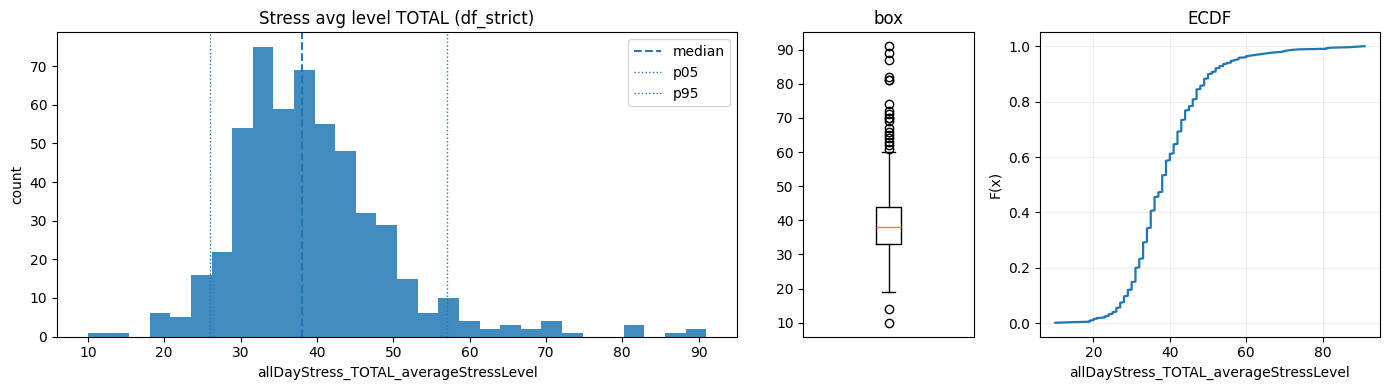

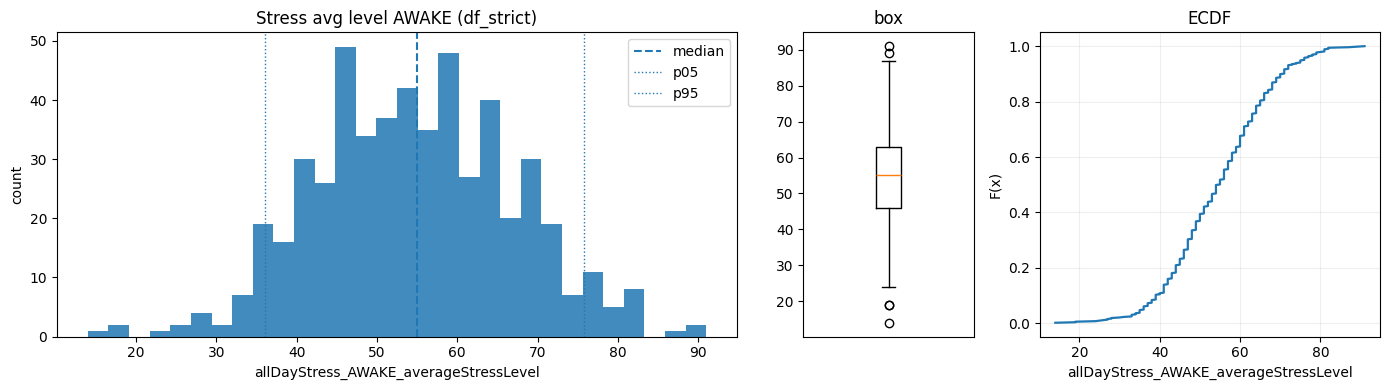

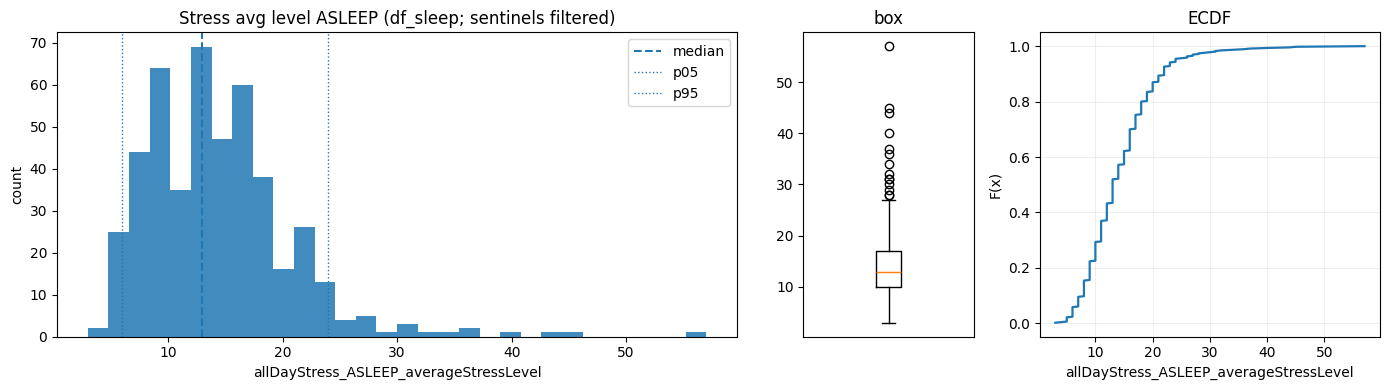

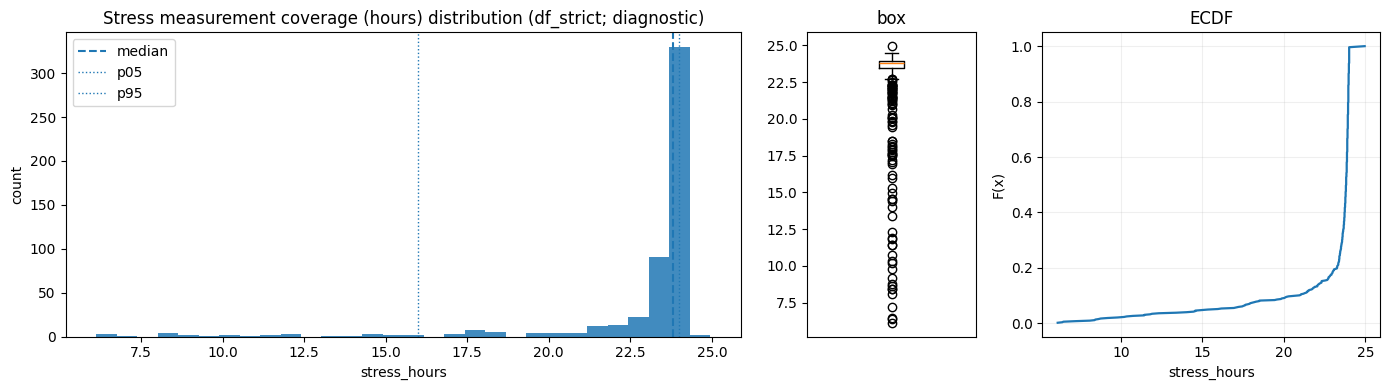

In [8]:
# Stress coverage metrics are diagnostic/context (quality/readiness), not primary physiological outcomes.
stress_dist_specs = [
    ('allDayStress_TOTAL_averageStressLevel', df_strict, 'Stress avg level TOTAL (df_strict)', 'dist_stress_avg_total_strict', False, None, True),
    ('allDayStress_AWAKE_averageStressLevel', df_strict, 'Stress avg level AWAKE (df_strict)', 'dist_stress_avg_awake_strict', False, None, True),
    ('allDayStress_ASLEEP_averageStressLevel', df_sleep, 'Stress avg level ASLEEP (df_sleep; sentinels filtered)', 'dist_stress_avg_asleep_sleep', False, None, True),
    ('stress_hours', df_strict, 'Stress measurement coverage (hours) distribution (df_strict; diagnostic)', 'dist_stress_hours_strict', False, None, True),
]

for col, frame, title, fig_name, integer_bins, clip_upper_q, add_ecdf in stress_dist_specs:
    tmp = frame.copy()
    if col == 'allDayStress_ASLEEP_averageStressLevel' and col in tmp.columns:
        tmp[col] = pd.to_numeric(tmp[col], errors='coerce')
        tmp.loc[tmp[col] < 0, col] = np.nan
    plot_distribution(
        tmp,
        col,
        title=title,
        bins=30,
        fig_name=fig_name,
        integer_bins=integer_bins,
        clip_upper_q=clip_upper_q,
        add_ecdf=add_ecdf,
    )


### 2.3 Heart distributions (`df_strict`)


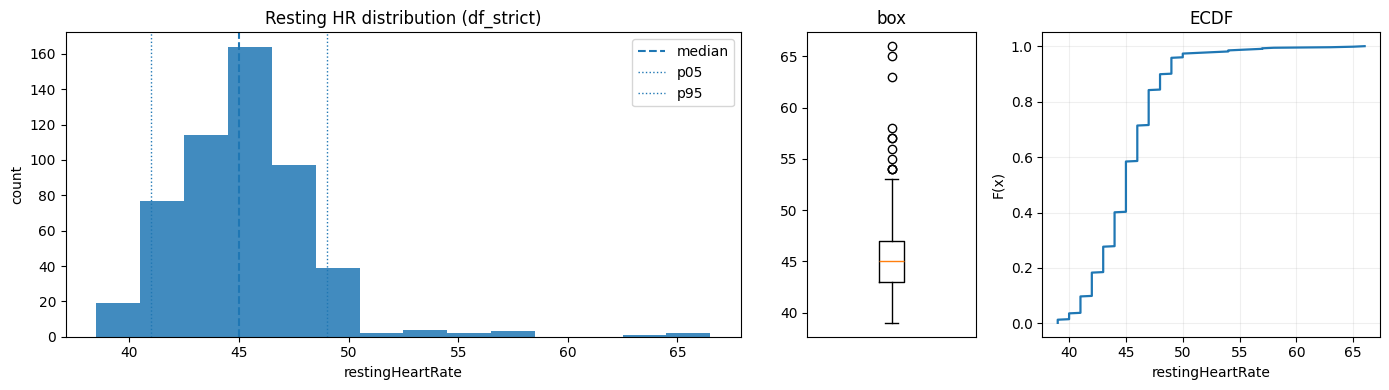

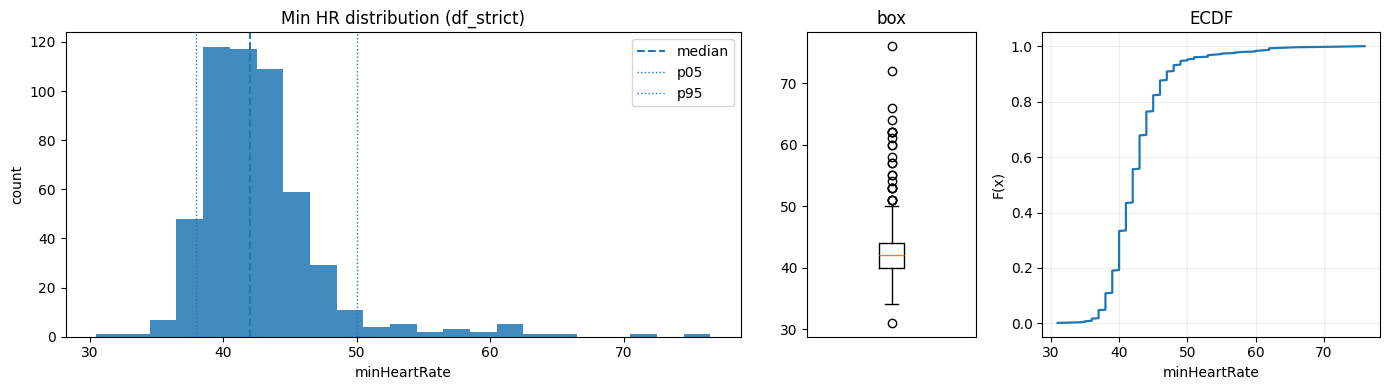

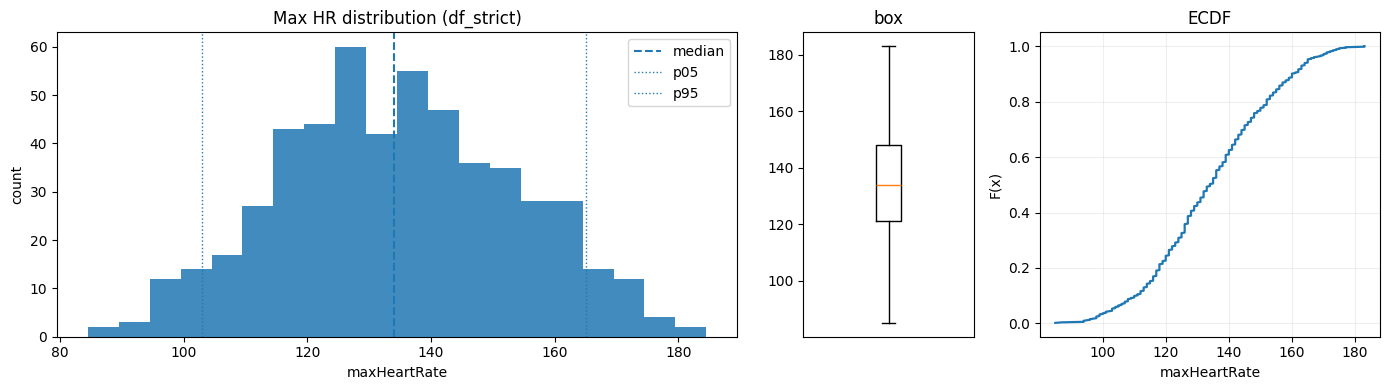

In [9]:
heart_specs = [
    ('restingHeartRate', 'Resting HR distribution (df_strict)', 'dist_resting_hr_strict', np.arange(38.5, 68.0, 2.0)),
    ('minHeartRate', 'Min HR distribution (df_strict)', 'dist_min_hr_strict', np.arange(30.5, 78.0, 2.0)),
    ('maxHeartRate', 'Max HR distribution (df_strict)', 'dist_max_hr_strict', np.arange(84.5, 185.0, 5.0)),
]
for col, title, fig_name, bin_edges in heart_specs:
    plot_distribution(
        df_strict,
        col,
        title=title,
        bins=30,
        fig_name=fig_name,
        integer_bins=False,
        add_ecdf=True,
        bin_edges=bin_edges,
    )


### 2.4 Body Battery distributions (`df_strict`, `df_strict_d`)


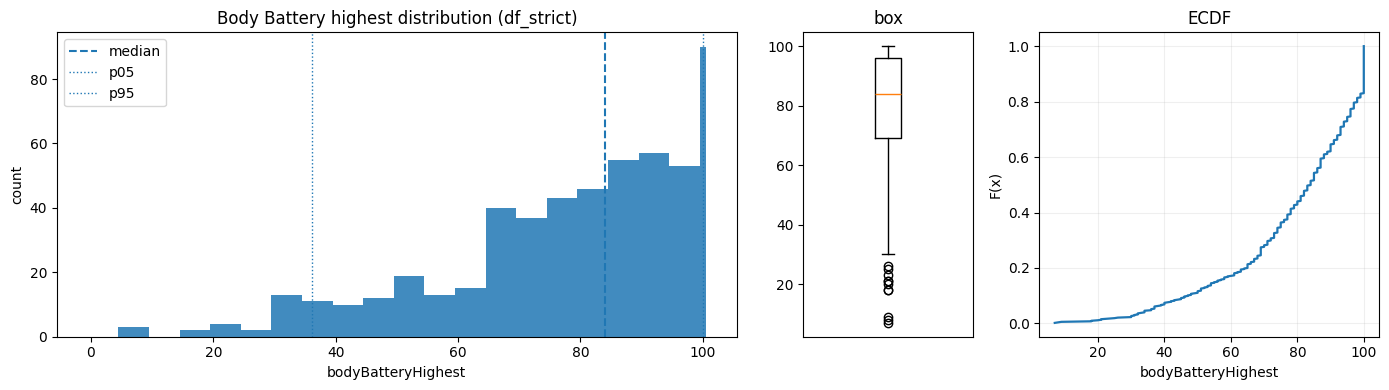

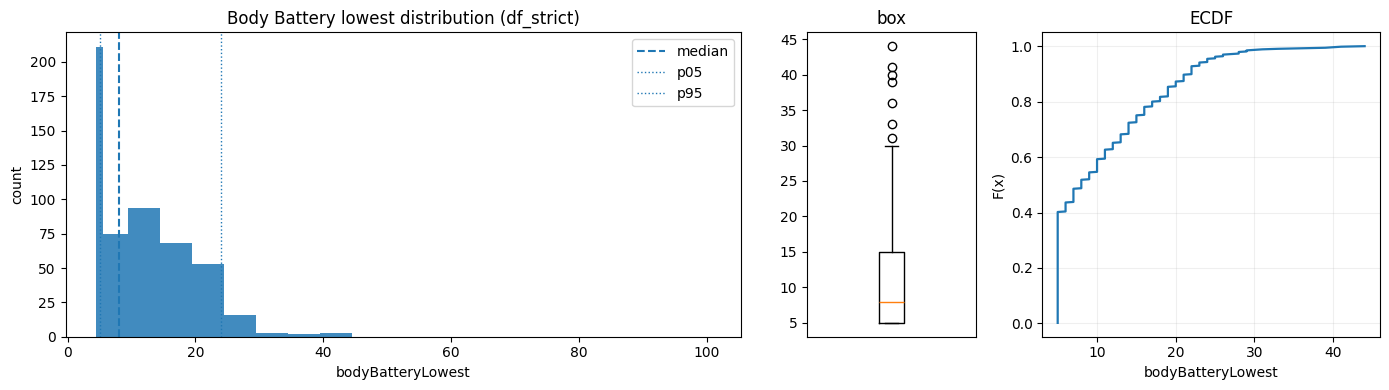

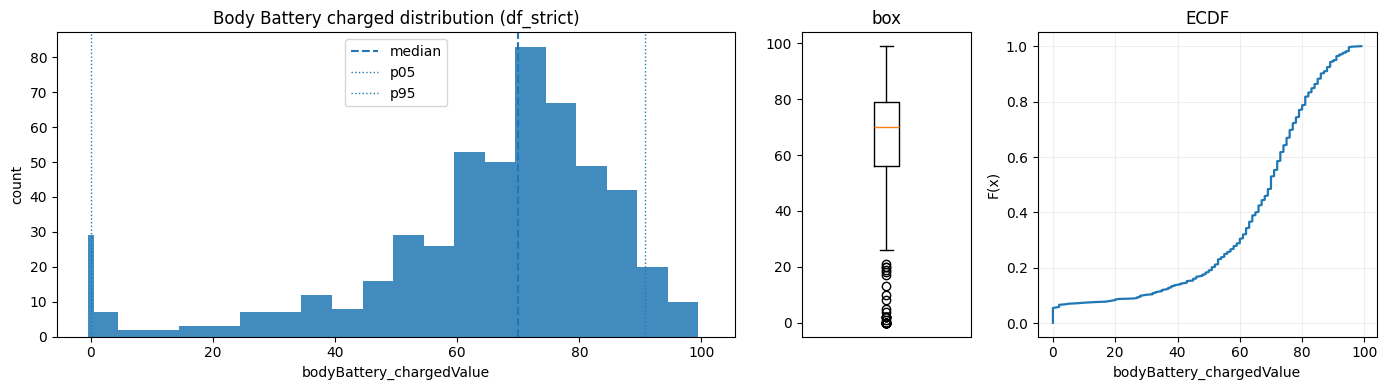

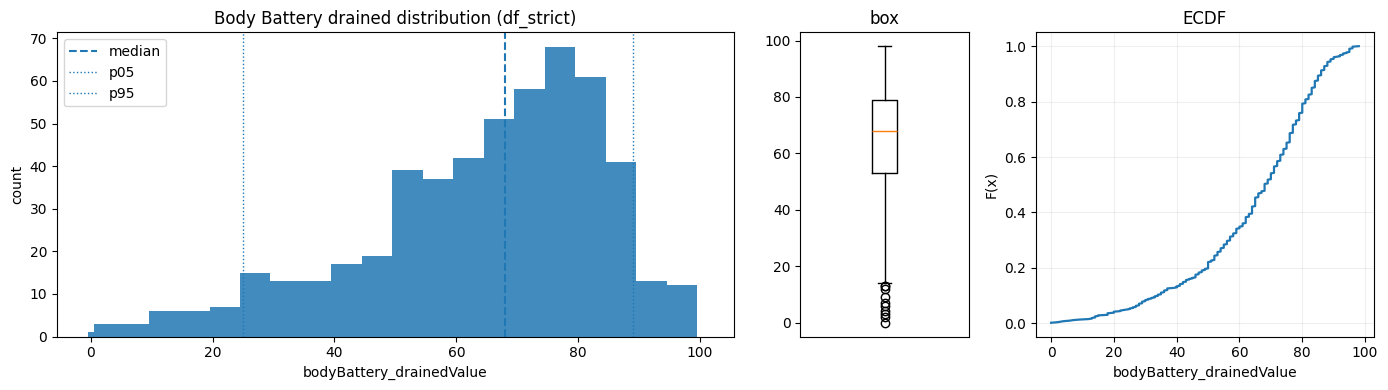

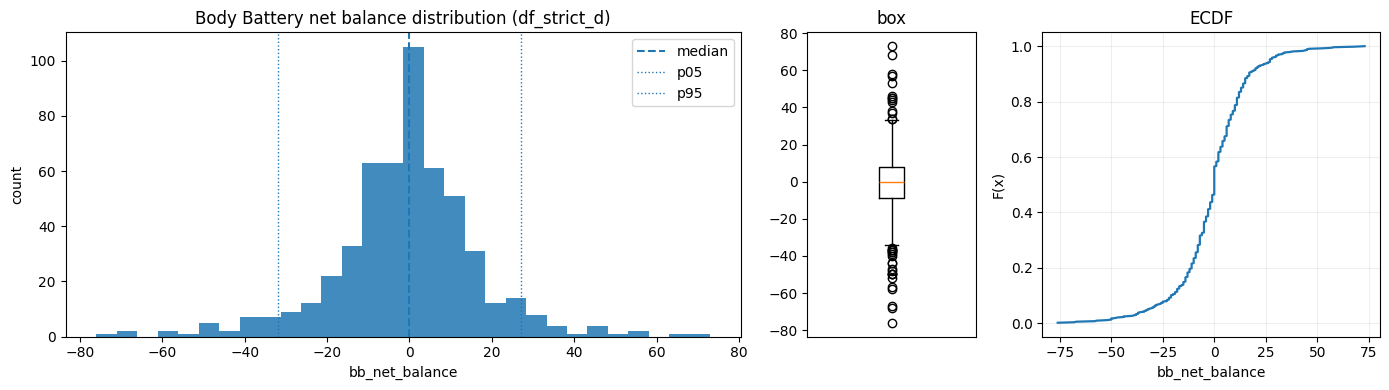

In [10]:
bb_high_edges = np.r_[np.arange(-0.5, 100.0, 5.0), 100.5]
bb_low_edges = np.r_[4.5, 5.5, np.arange(9.5, 100.0, 5.0), 100.5]
bb_zero_hundred_edges = np.r_[-0.5, 0.5, np.arange(4.5, 100.0, 5.0), 100.5]

bb_candidates = [
    ('bodyBatteryHighest', df_strict, 'Body Battery highest distribution (df_strict)', 'dist_bb_highest_strict', bb_high_edges, None, True),
    ('bodyBatteryLowest', df_strict, 'Body Battery lowest distribution (df_strict)', 'dist_bb_lowest_strict', bb_low_edges, None, True),
    ('bodyBattery_chargedValue', df_strict, 'Body Battery charged distribution (df_strict)', 'dist_bb_charged_strict', bb_zero_hundred_edges, None, True),
    ('bodyBattery_drainedValue', df_strict, 'Body Battery drained distribution (df_strict)', 'dist_bb_drained_strict', bb_zero_hundred_edges, None, True),
    ('bb_net_balance', df_strict_d, 'Body Battery net balance distribution (df_strict_d)', 'dist_bb_net_balance_strict', None, None, True),
]

for col, frame, title, fig_name, bin_edges, clip_upper_q, add_ecdf in bb_candidates:
    plot_distribution(
        frame,
        col,
        title=title,
        bins=30,
        fig_name=fig_name,
        integer_bins=False,
        clip_upper_q=clip_upper_q,
        add_ecdf=add_ecdf,
        bin_edges=bin_edges,
    )


### 2.5 Sleep distributions (`df_sleep`, `df_sleep_d`)


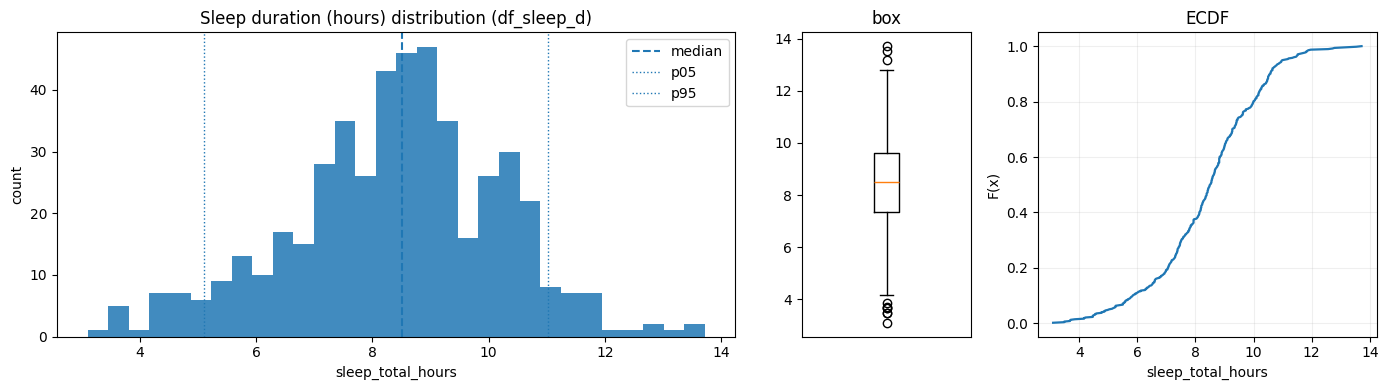

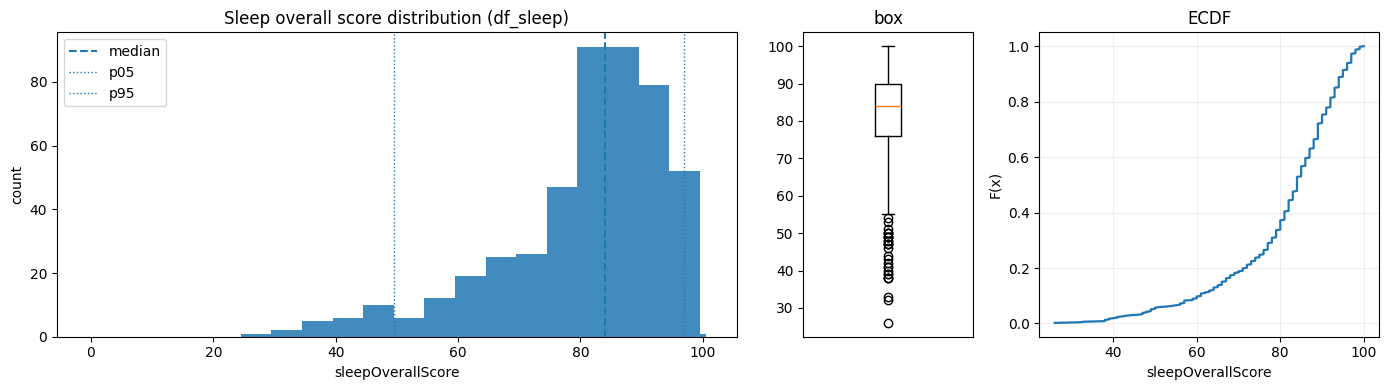

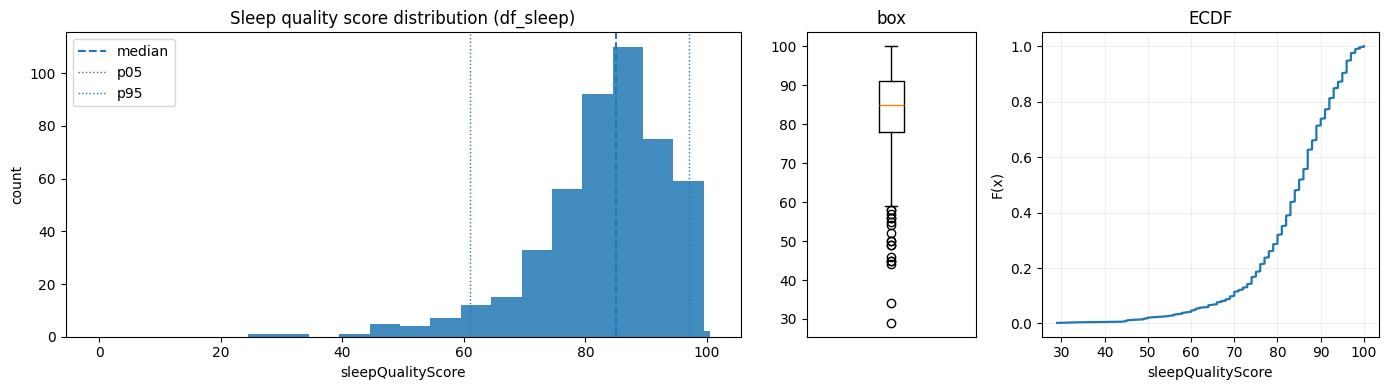

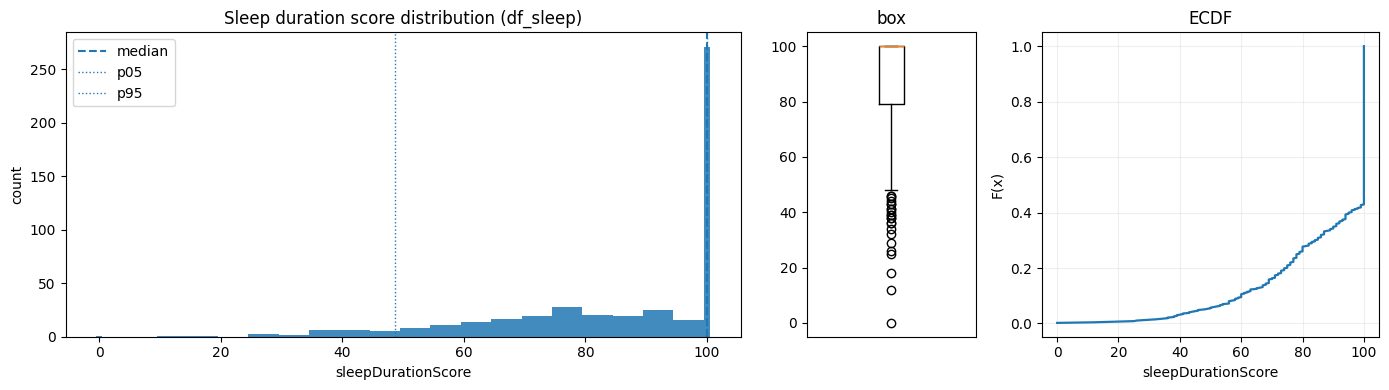

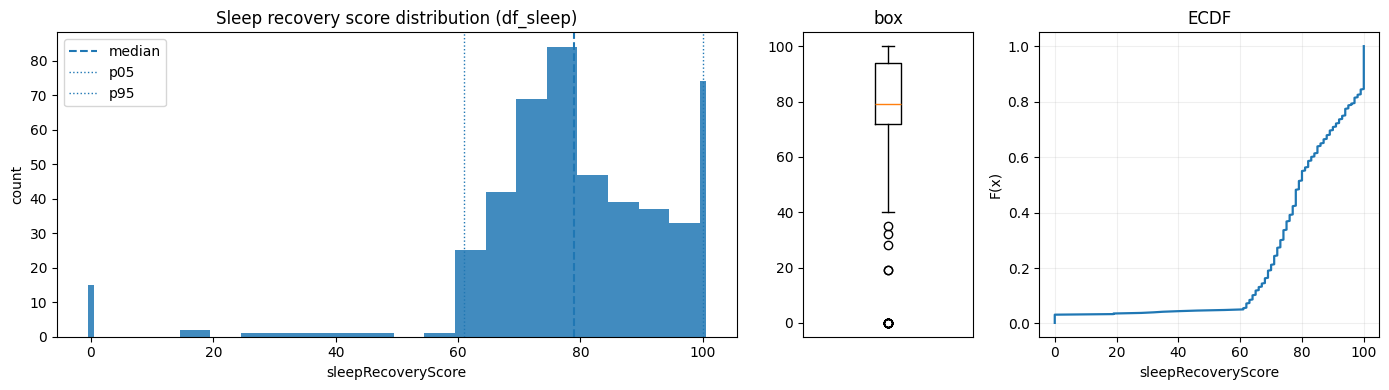

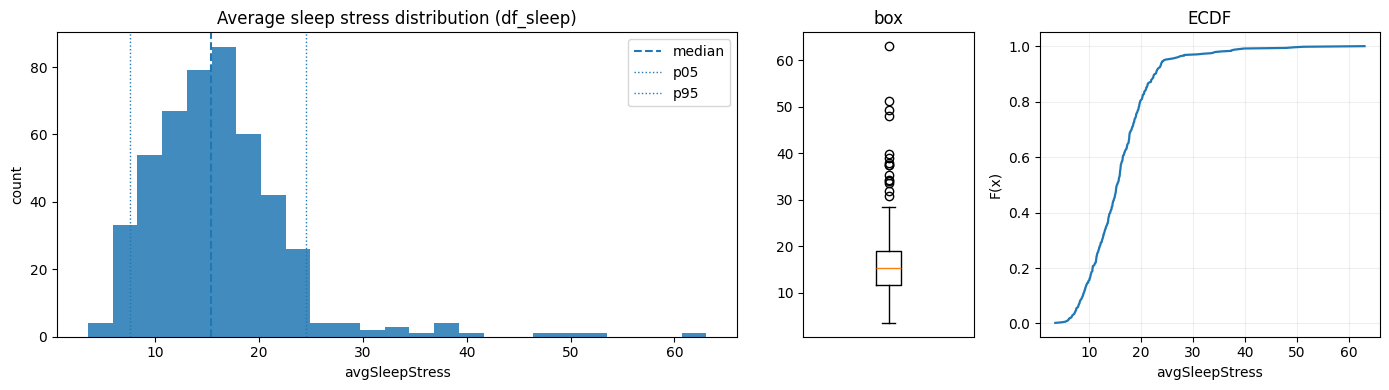

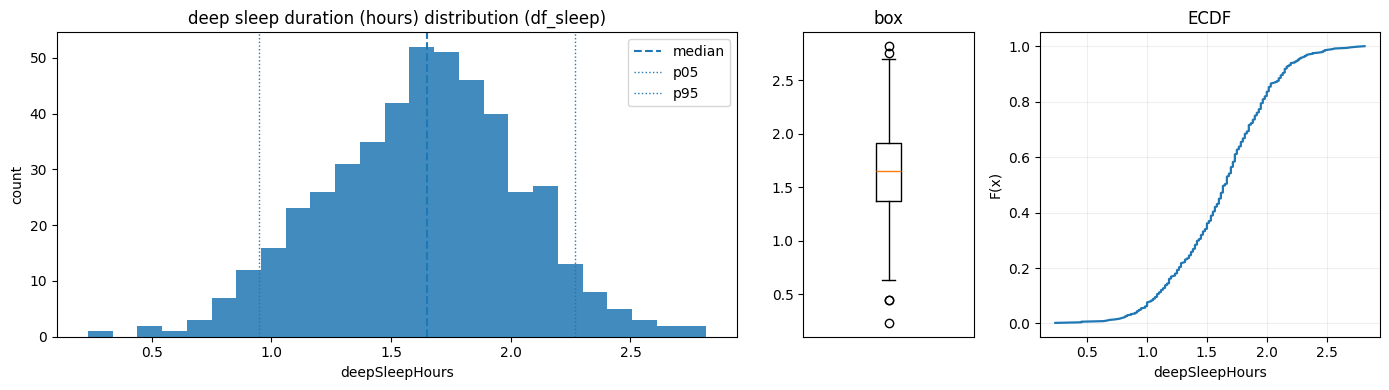

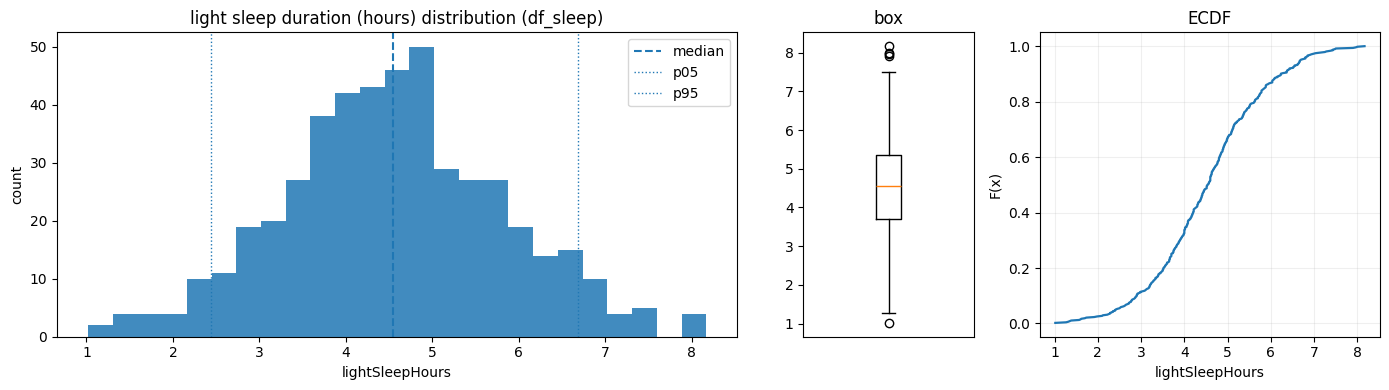

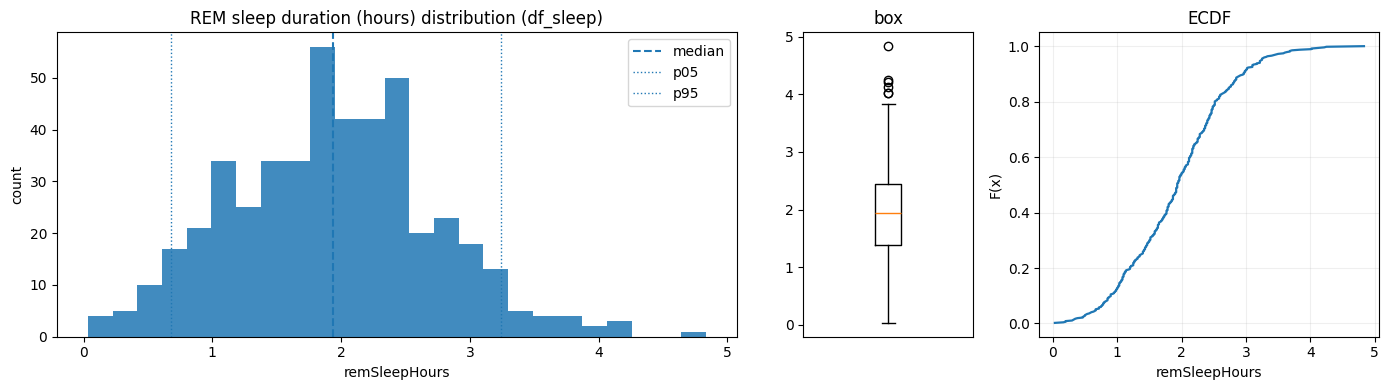

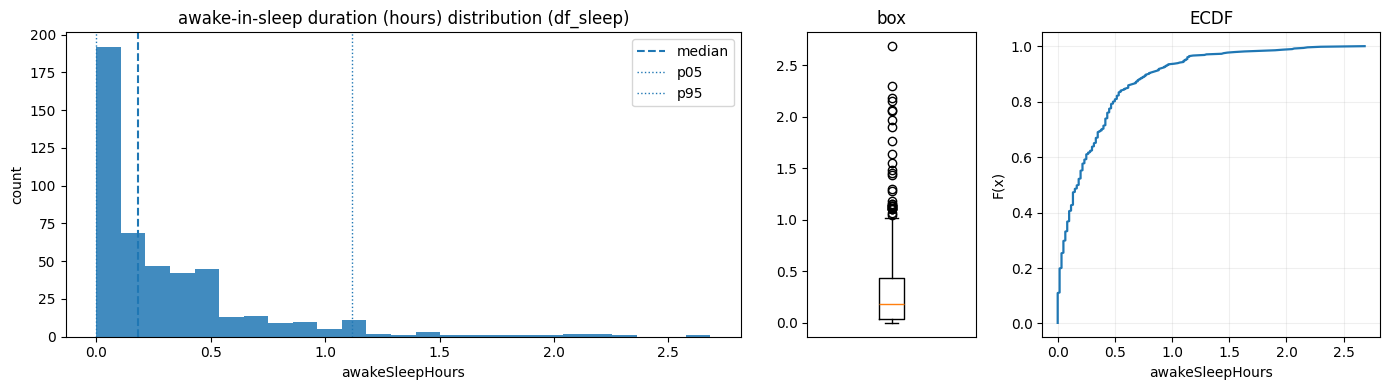

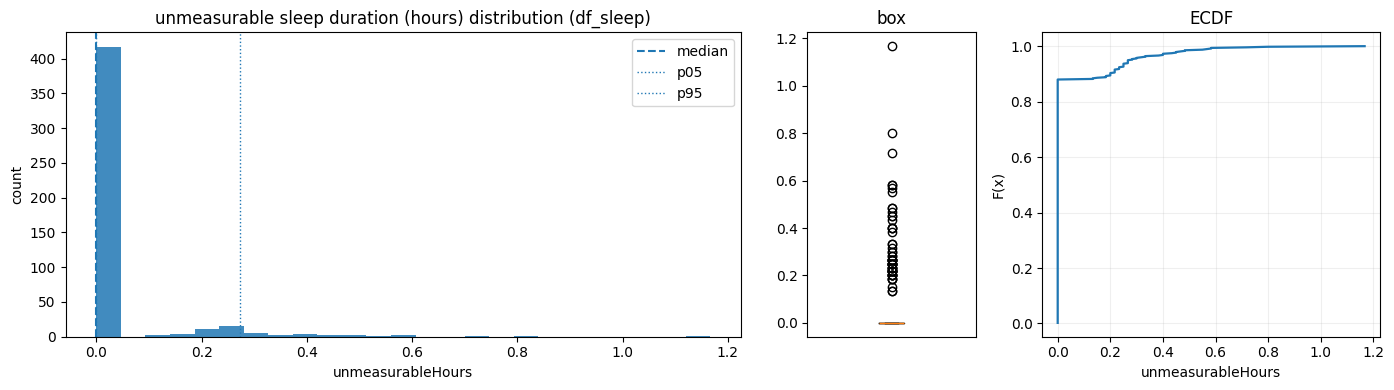

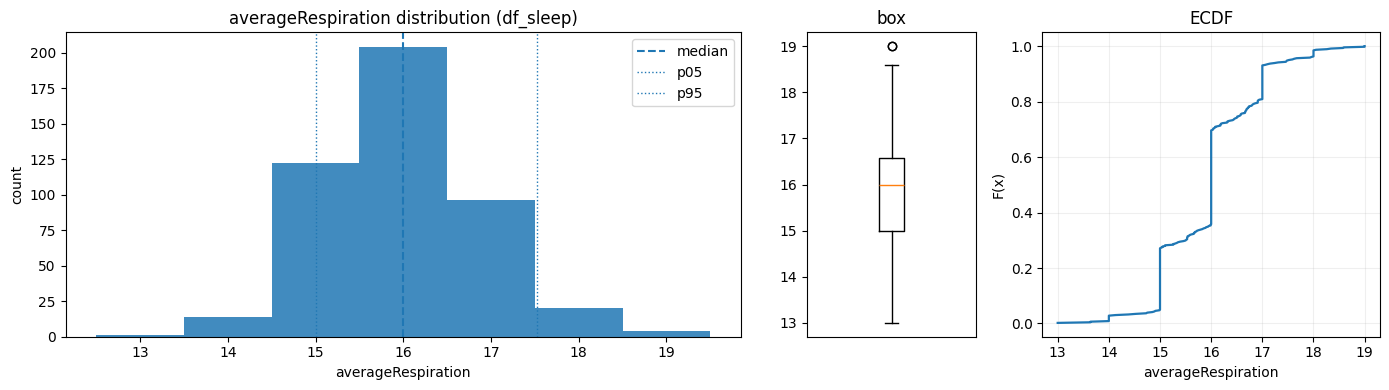

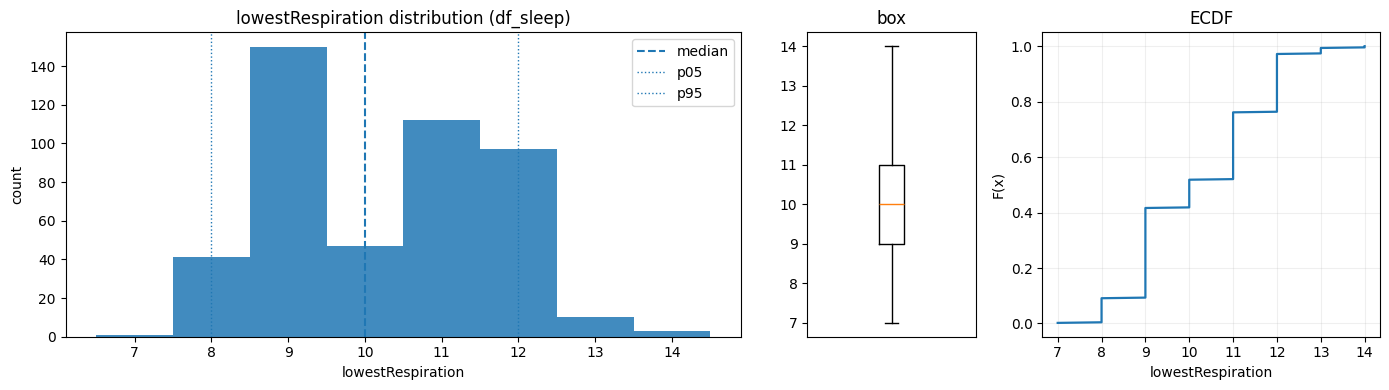

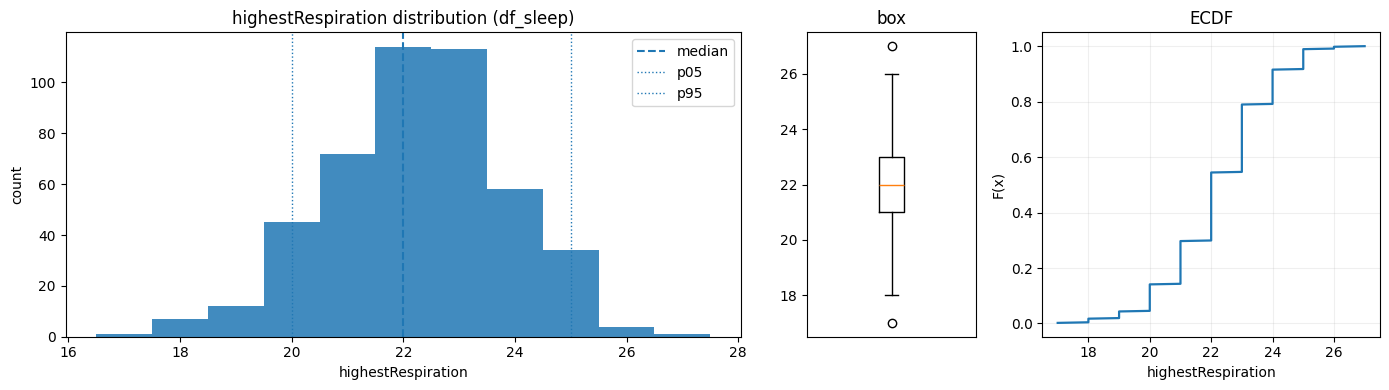

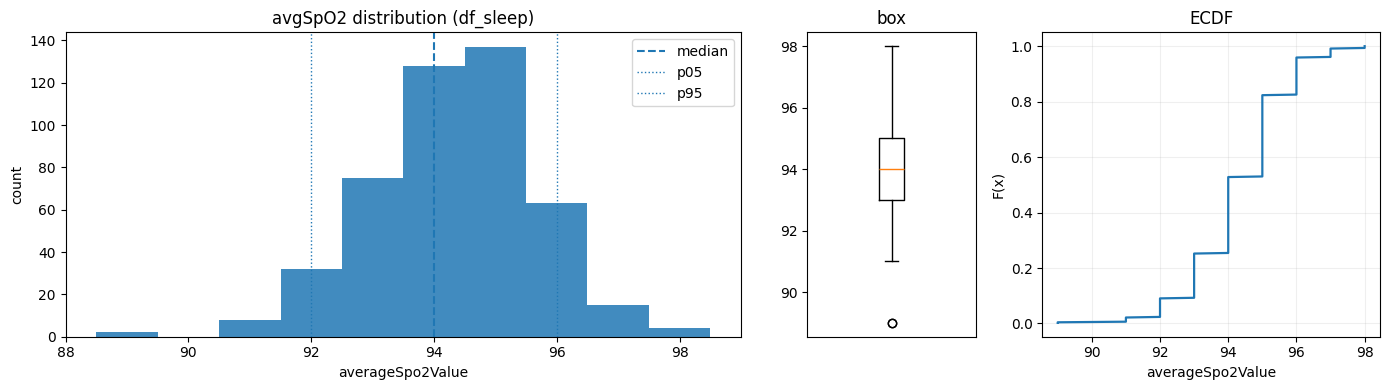

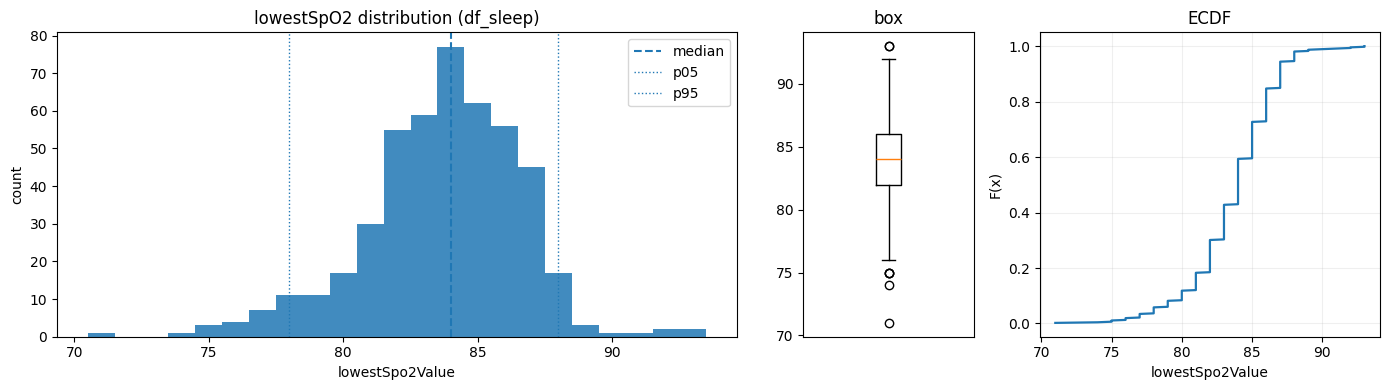

In [11]:
score_edges_100 = np.r_[np.arange(-0.5, 100.0, 5.0), 100.5]
score_edges_0_100 = np.r_[-0.5, 0.5, np.arange(4.5, 100.0, 5.0), 100.5]

sleep_metrics = [
    ('sleep_total_hours', 'Sleep duration (hours) distribution (df_sleep_d)', 30, 'dist_sleep_total_hours', df_sleep_d, False, None, True, None),
    ('sleepOverallScore', 'Sleep overall score distribution (df_sleep)', 25, 'dist_sleep_overall_score', df_sleep, False, None, True, score_edges_100),
    ('sleepQualityScore', 'Sleep quality score distribution (df_sleep)', 25, 'dist_sleep_quality_score', df_sleep, False, None, True, score_edges_100),
    ('sleepDurationScore', 'Sleep duration score distribution (df_sleep)', 25, 'dist_sleep_duration_score', df_sleep, False, None, True, score_edges_0_100),
    ('sleepRecoveryScore', 'Sleep recovery score distribution (df_sleep)', 25, 'dist_sleep_recovery_score', df_sleep, False, None, True, score_edges_0_100),
    ('avgSleepStress', 'Average sleep stress distribution (df_sleep)', 25, 'dist_avg_sleep_stress', df_sleep, False, None, True, None),
]

for col, title, bins, fig_name, frame, integer_bins, clip_upper_q, add_ecdf, bin_edges in sleep_metrics:
    plot_distribution(
        frame,
        col,
        title=title,
        bins=bins,
        fig_name=fig_name,
        integer_bins=integer_bins,
        clip_upper_q=clip_upper_q,
        add_ecdf=add_ecdf,
        bin_edges=bin_edges,
    )

# Sleep stage duration distributions (hours) — useful before segmented sleep analysis.
stage_hour_specs = [
    ('deepSleepSeconds', 'deep sleep duration (hours) distribution', 'dist_deep_sleep_hours'),
    ('lightSleepSeconds', 'light sleep duration (hours) distribution', 'dist_light_sleep_hours'),
    ('remSleepSeconds', 'REM sleep duration (hours) distribution', 'dist_rem_sleep_hours'),
    ('awakeSleepSeconds', 'awake-in-sleep duration (hours) distribution', 'dist_awake_sleep_hours'),
    ('unmeasurableSeconds', 'unmeasurable sleep duration (hours) distribution', 'dist_unmeasurable_sleep_hours'),
]
for sec_col, title, fig_name in stage_hour_specs:
    if sec_col in df_sleep.columns:
        tmp = df_sleep[['calendarDate', sec_col]].copy()
        tmp[sec_col.replace('Seconds', 'Hours')] = pd.to_numeric(tmp[sec_col], errors='coerce') / 3600.0
        plot_distribution(
            tmp,
            sec_col.replace('Seconds', 'Hours'),
            title=f'{title} (df_sleep)',
            bins=25,
            fig_name=fig_name,
            add_ecdf=True,
        )

# Respiration and SpO2 often look jagged due to quantization/discrete values; integer-aligned bins + ECDF help.
for col in ['averageRespiration', 'lowestRespiration', 'highestRespiration']:
    if col in df_sleep.columns:
        plot_distribution(
            df_sleep,
            col,
            title=f'{col} distribution (df_sleep)',
            bins=25,
            fig_name=f'dist_{col}',
            integer_bins=True,
            add_ecdf=True,
        )

# SpO2 may exist under legacy and sleep-summary naming variants. Prefer one coherent pair to avoid duplicate plots.
spo2_pairs = [
    [('averageSpo2Value', 'avgSpO2'), ('lowestSpo2Value', 'lowestSpO2')],
    [('spo2SleepAverageSPO2', 'sleepAvgSpO2'), ('spo2SleepLowestSPO2', 'sleepLowestSpO2')],
]
selected_spo2 = []
for pair in spo2_pairs:
    if all(col in df_sleep.columns for col, _ in pair):
        selected_spo2 = pair
        break
if not selected_spo2:
    fallback = [
        ('averageSpo2Value', 'avgSpO2'),
        ('lowestSpo2Value', 'lowestSpO2'),
        ('spo2SleepAverageSPO2', 'sleepAvgSpO2'),
        ('spo2SleepLowestSPO2', 'sleepLowestSpO2'),
    ]
    selected_spo2 = [(c, label) for c, label in fallback if c in df_sleep.columns]

for col, label in selected_spo2:
    plot_distribution(
        df_sleep,
        col,
        title=f'{label} distribution (df_sleep)',
        bins=25,
        fig_name=f'dist_{col}',
        integer_bins=True,
        add_ecdf=True,
    )


### Block D findings (finalized)

- `totalSteps` is the clearest mixture-like distribution in this notebook: a low-activity / near-home regime and a more active regime with a broad peak around ~5k steps.
- `step_length_m` is sharply centered around ~0.78 m/step with asymmetric tails, indicating a dominant walking regime plus a smaller faster-gait/running component.
- `floorsAscendedInMeters` shows a weaker version of the same pattern: a meaningful point mass at `0` (no-climb days) plus a broad main body centered roughly around ~20–45 m, not a clean Gaussian shape.
- Duration metrics are more interpretable in hours (`active_hours`, `highly_active_hours`) than raw seconds; this keeps Stage 2 plots comparable with sleep/body-battery hour-based views.
- Stress coverage (`stress_hours`) is retained as a quality/readiness diagnostic, not as a primary physiological outcome.
- Garmin/model boundaries are visible in distributions (e.g., `bodyBatteryLowest` floor near 5, score ceilings at 100), so interpretation explicitly treats these as algorithmic boundaries, not natural continuous variables.
- Sleep metrics show expected quality structure: poor-quality nights are shorter and more stressed, while excellent nights are longer and less stressed (see segmented findings below).


## 3. Block D/E bridge — Segmented distributions

Question: **How do key distributions change across meaningful cohorts (weekday/weekend, sleep-quality buckets, etc.)?**

Planned implementation (next phase):
- weekday vs weekend comparisons for activity / stress / sleep core metrics
- Garmin sleep quality bucket comparisons (`poor/fair/good/excellent`)
- selective quality-slice comparisons only where they add information


### 3.1 Weekday vs weekend segmented distributions

Question: **Do key metrics differ between weekdays and weekends?**

This is a compact first segmentation pass to test whether obvious behavioral cohorts change the distributions.


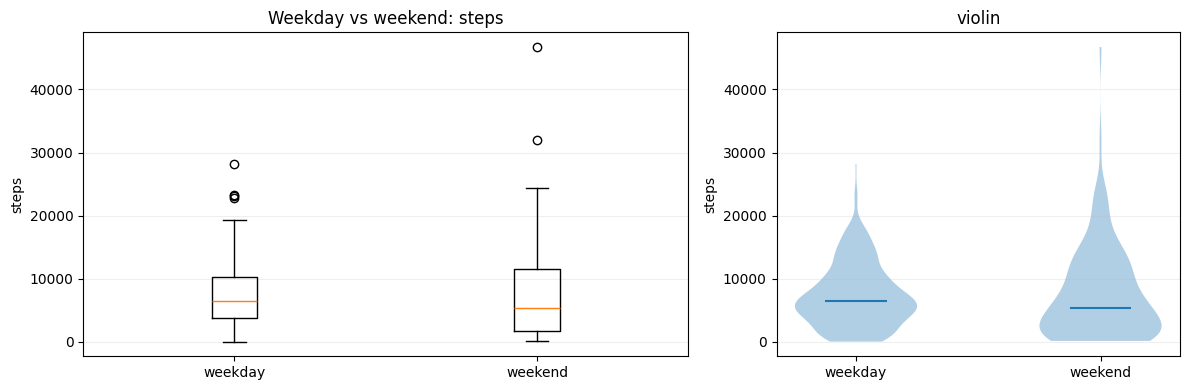

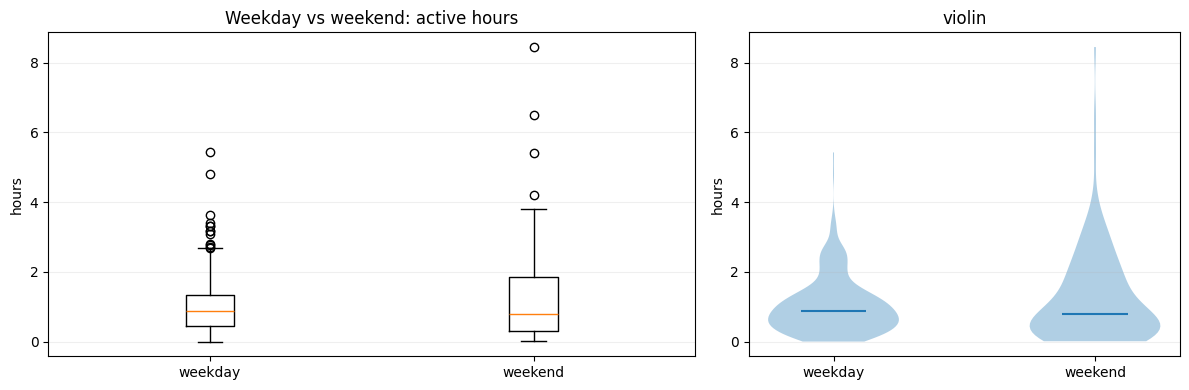

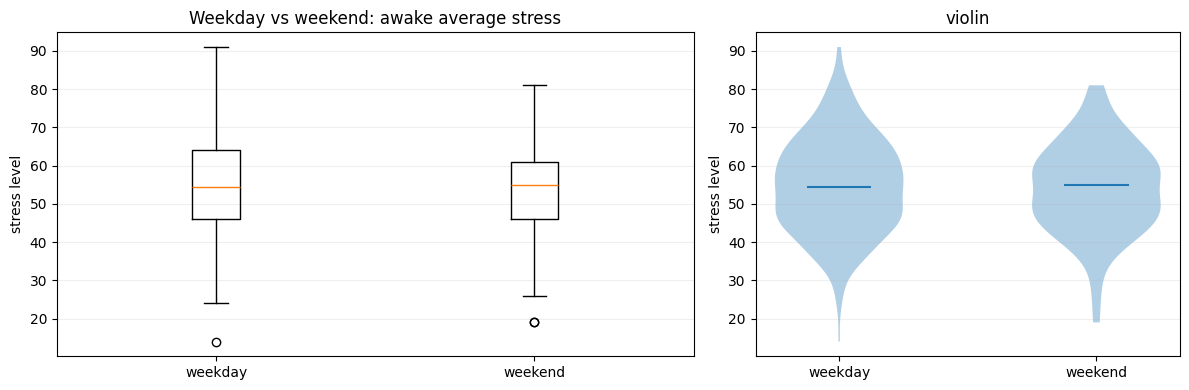

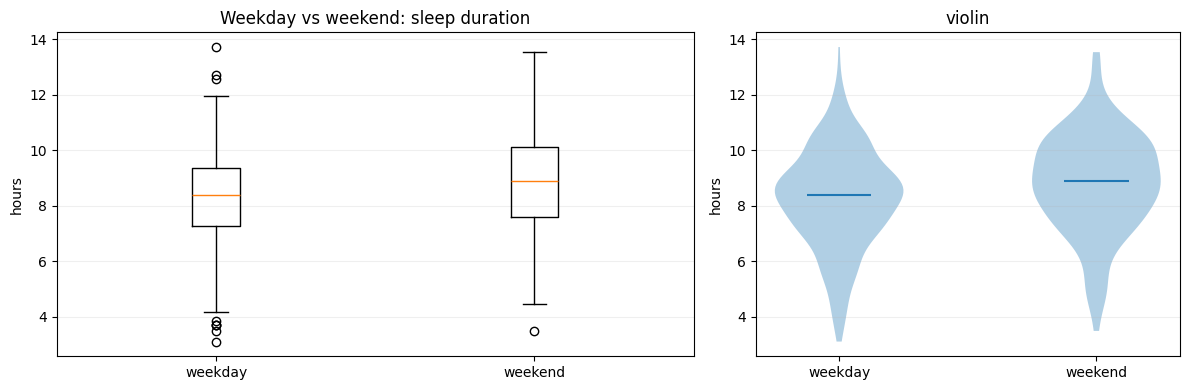

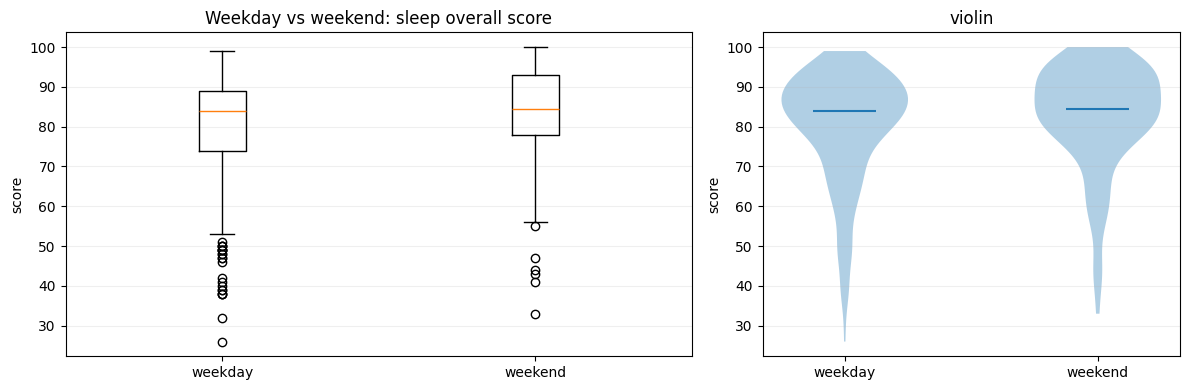

In [12]:
def _with_weekpart(frame: pd.DataFrame) -> pd.DataFrame:
    out = frame.copy()
    out['calendarDate'] = pd.to_datetime(out['calendarDate'], errors='coerce').dt.normalize()
    out = out.dropna(subset=['calendarDate'])
    wd = out['calendarDate'].dt.weekday
    out['is_weekend'] = wd >= 5
    out['weekpart'] = np.where(out['is_weekend'], 'weekend', 'weekday')
    return out


def plot_segmented_box(
    frame: pd.DataFrame,
    col: str,
    *,
    segment_col: str,
    order: list[str],
    title: str,
    ylabel: str | None = None,
    fig_name: str | None = None,
    clock_axis: bool = False,
):
    if col not in frame.columns or segment_col not in frame.columns:
        print(f'Skip segmented box: missing {col} or {segment_col}')
        return
    tmp = frame[[col, segment_col]].copy()
    tmp[col] = pd.to_numeric(tmp[col], errors='coerce')
    tmp = tmp.dropna(subset=[col, segment_col])
    if tmp.empty:
        print(f'Skip segmented box: no data for {col}')
        return

    groups = [tmp.loc[tmp[segment_col] == key, col].to_numpy() for key in order]
    if sum(len(g) for g in groups) == 0:
        print(f'Skip segmented box: empty groups for {col}')
        return

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'width_ratios': [3, 2]})
    ax_box, ax_violin = axes

    ax_box.boxplot(groups, tick_labels=order, vert=True)
    ax_box.set_title(title)
    if ylabel:
        ax_box.set_ylabel(ylabel)
    ax_box.grid(axis='y', alpha=0.2)

    vp = ax_violin.violinplot(groups, showmeans=False, showmedians=True, showextrema=False)
    for body in vp['bodies']:
        body.set_alpha(0.35)
    if 'cmedians' in vp:
        vp['cmedians'].set_linewidth(1.5)
    ax_violin.set_xticks(range(1, len(order)+1))
    ax_violin.set_xticklabels(order)
    ax_violin.set_title('violin')
    if ylabel:
        ax_violin.set_ylabel(ylabel)
    ax_violin.grid(axis='y', alpha=0.2)

    if clock_axis:
        # Wrapped hour axis: values may be in [-6, +12], but labels shown as local clock [00..23].
        for ax in [ax_box, ax_violin]:
            y0, y1 = ax.get_ylim()
            lo = int(np.floor(y0))
            hi = int(np.ceil(y1))
            span = max(1, hi - lo)
            step = 1 if span <= 14 else 2
            ticks = np.arange(lo, hi + 1, step)
            ax.set_yticks(ticks)
            ax.set_yticklabels([f"{int(t % 24):02d}" for t in ticks])
            ax.set_ylabel((ylabel or col) + ' (clock)')

    fig.tight_layout()
    if fig_name is not None:
        maybe_savefig(fig, fig_name, save_figs=SAVE_FIGS, fig_dir=FIG_DIR, dpi=DPI, fmt=FIG_FMT)
    plt.show()
    plt.close(fig)


strict_seg = _with_weekpart(df_strict_d)
sleep_seg = _with_weekpart(df_sleep_d)

weekday_weekend_specs = [
    (strict_seg, 'totalSteps', 'Weekday vs weekend: steps', 'steps', 'seg_weekpart_steps_box'),
    (strict_seg, 'active_hours', 'Weekday vs weekend: active hours', 'hours', 'seg_weekpart_active_hours_box'),
    (strict_seg, 'allDayStress_AWAKE_averageStressLevel', 'Weekday vs weekend: awake average stress', 'stress level', 'seg_weekpart_awake_stress_box'),
    (sleep_seg, 'sleep_total_hours', 'Weekday vs weekend: sleep duration', 'hours', 'seg_weekpart_sleep_hours_box'),
    (sleep_seg, 'sleepOverallScore', 'Weekday vs weekend: sleep overall score', 'score', 'seg_weekpart_sleep_overall_box'),
]
for frame, col, title, ylabel, fig_name in weekday_weekend_specs:
    plot_segmented_box(frame, col, segment_col='weekpart', order=['weekday', 'weekend'], title=title, ylabel=ylabel, fig_name=fig_name)



### 3.2 Day-of-week segmented distributions (Mon–Sun)

Question: **Do patterns differ across specific weekdays (not just weekday vs weekend)?**

This helps detect weekly rhythm (e.g., Tuesday stress, weekend sleep extension) that may be hidden in the coarse weekday/weekend split.

For sleep metrics in this section, weekday is anchored to the **sleep onset day** (`calendarDate - 1`), not wake-up day.



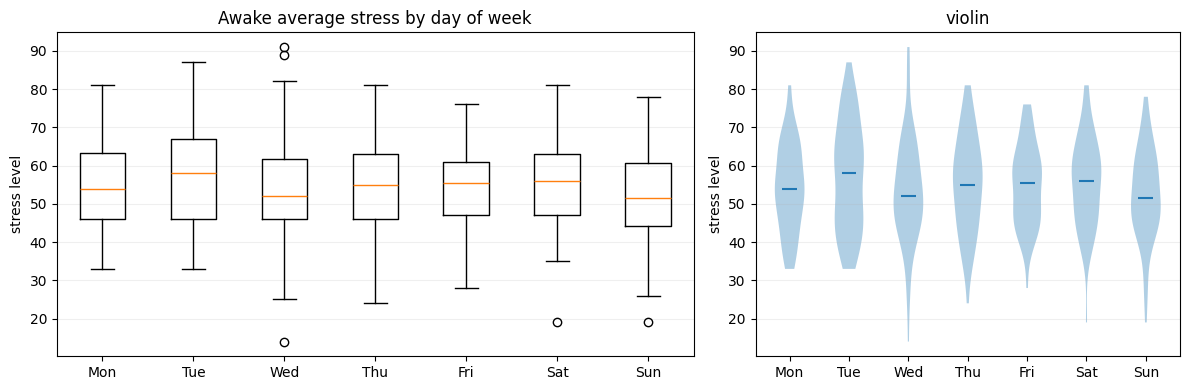

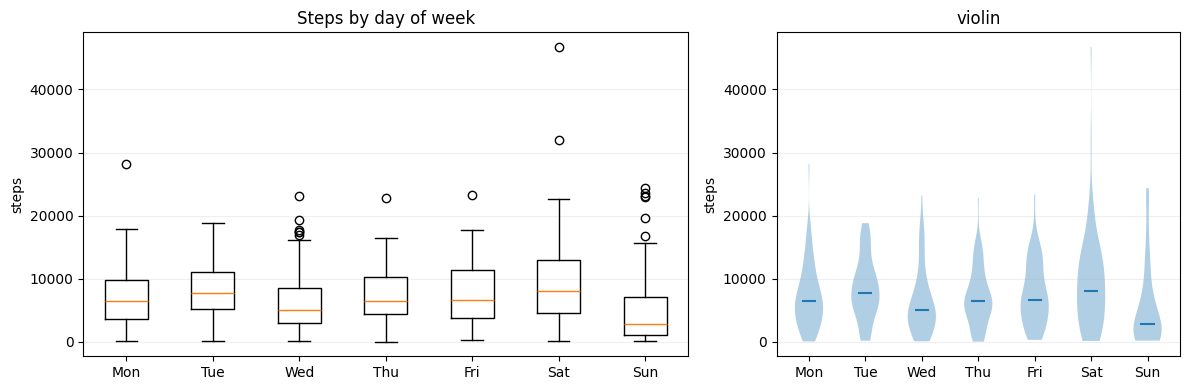

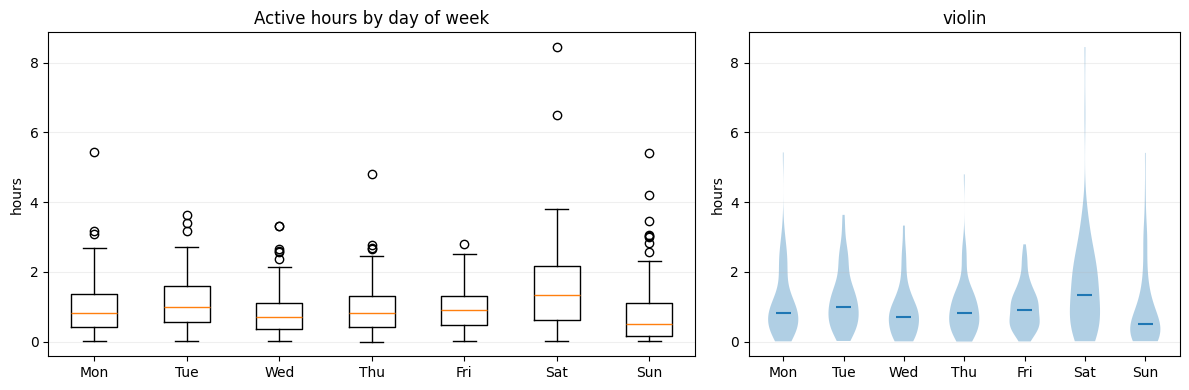

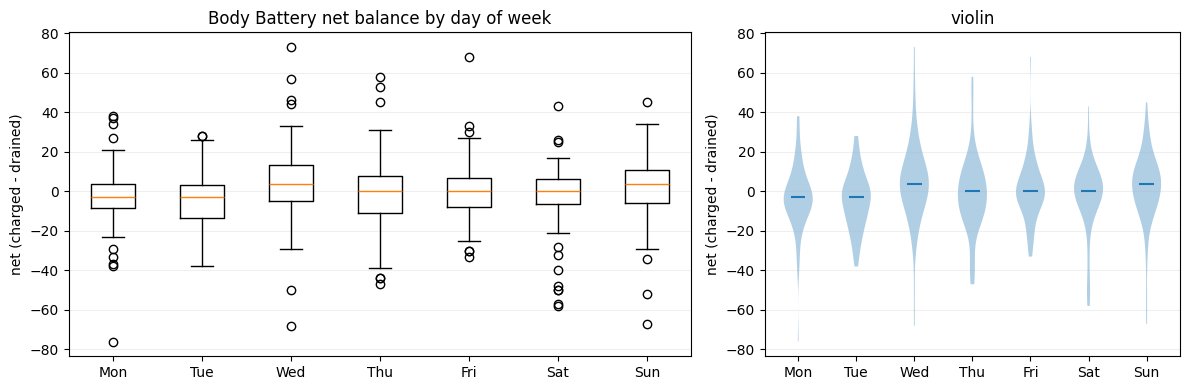

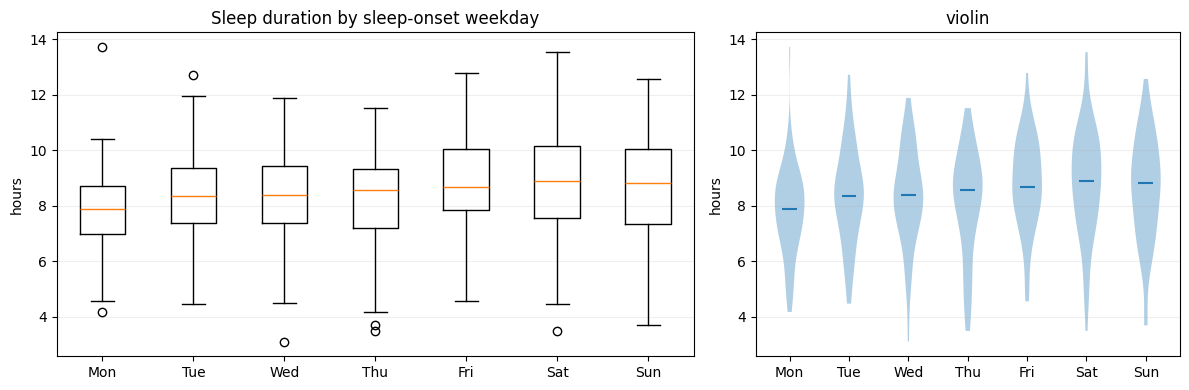

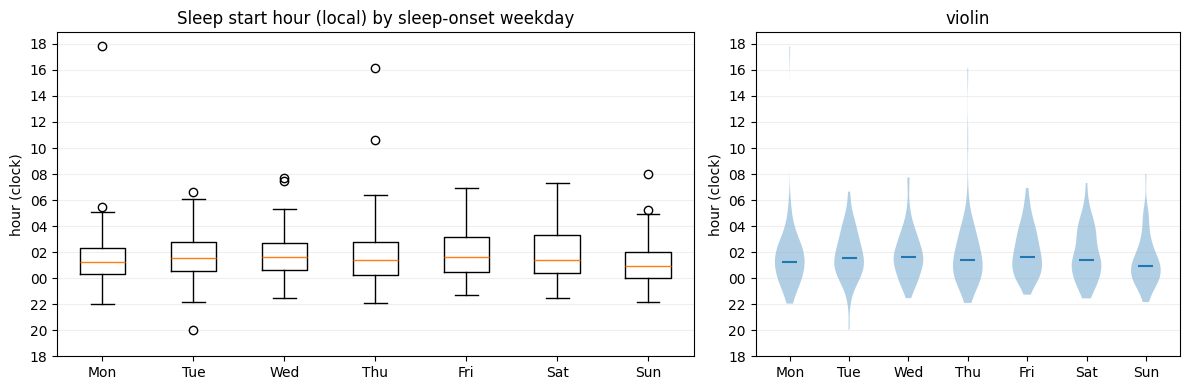

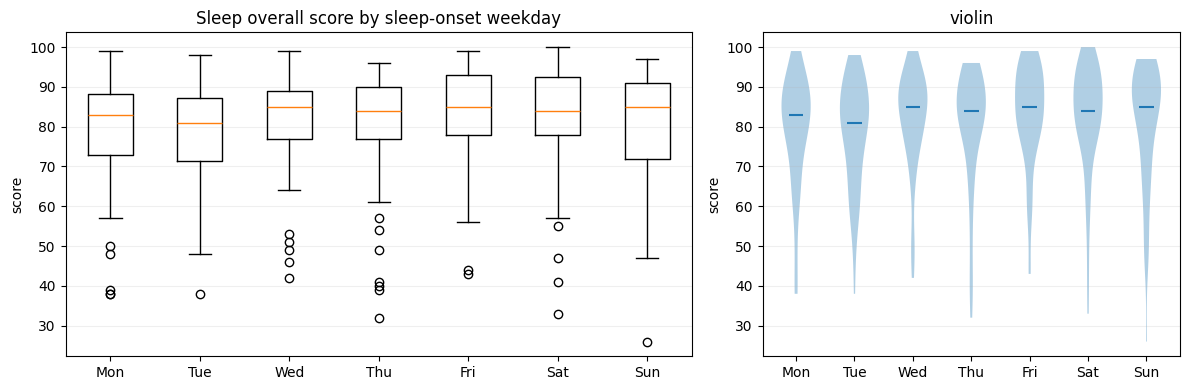

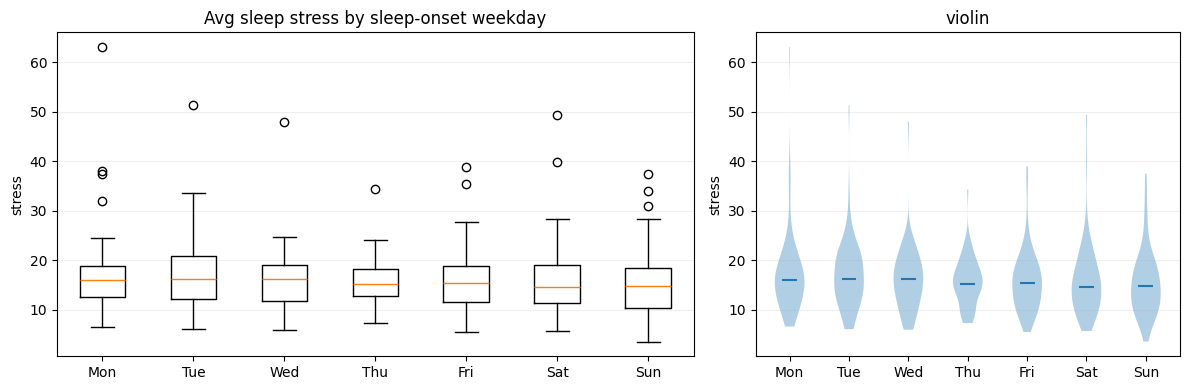

In [13]:
weekday_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']


def _with_weekday_name(frame: pd.DataFrame, *, day_shift: int = 0) -> pd.DataFrame:
    out = frame.copy()
    out['calendarDate'] = pd.to_datetime(out['calendarDate'], errors='coerce').dt.normalize()
    out = out.dropna(subset=['calendarDate'])
    if day_shift != 0:
        out['weekday_anchor_date'] = out['calendarDate'] + pd.to_timedelta(day_shift, unit='D')
    else:
        out['weekday_anchor_date'] = out['calendarDate']
    wd = out['weekday_anchor_date'].dt.weekday
    out['weekday_name'] = pd.Categorical(
        pd.Series(wd).map({0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}).values,
        categories=weekday_order,
        ordered=True,
    )
    return out


def _ensure_bb_net_alias(frame: pd.DataFrame) -> pd.DataFrame:
    out = frame.copy()
    if 'bodyBatteryNetBalance' in out.columns:
        return out
    if 'bb_net_balance' in out.columns:
        out['bodyBatteryNetBalance'] = pd.to_numeric(out['bb_net_balance'], errors='coerce')
        return out
    if {'bodyBattery_chargedValue', 'bodyBattery_drainedValue'}.issubset(out.columns):
        out['bodyBatteryNetBalance'] = (
            pd.to_numeric(out['bodyBattery_chargedValue'], errors='coerce')
            - pd.to_numeric(out['bodyBattery_drainedValue'], errors='coerce')
        )
    return out


def _ensure_sleep_start_hour_local_quick(frame: pd.DataFrame) -> pd.DataFrame:
    out = frame.copy()
    if 'sleep_start_hour_local' in out.columns:
        return out
    if 'sleepStartTimestampGMT' not in out.columns:
        return out

    sleep_start_utc = pd.to_datetime(
        pd.to_numeric(out['sleepStartTimestampGMT'], errors='coerce'),
        unit='s',
        utc=True,
        errors='coerce',
    )

    offset_h = pd.Series(np.nan, index=out.index, dtype='float64')
    for gmt_col, local_col in [('wellnessStartTimeGmt', 'wellnessStartTimeLocal'), ('wellnessEndTimeGmt', 'wellnessEndTimeLocal')]:
        if gmt_col in out.columns and local_col in out.columns:
            gmt_ts = pd.to_datetime(out[gmt_col], errors='coerce')
            local_ts = pd.to_datetime(out[local_col], errors='coerce')
            delta_h = (local_ts - gmt_ts).dt.total_seconds() / 3600.0
            offset_h = offset_h.where(~offset_h.isna(), delta_h)

    local_dt = sleep_start_utc.copy()
    mask = sleep_start_utc.notna() & offset_h.notna()
    if mask.any():
        local_dt.loc[mask] = sleep_start_utc.loc[mask] + pd.to_timedelta(offset_h.loc[mask], unit='h')

    out['sleep_start_hour_local'] = (
        local_dt.dt.hour.astype('float64')
        + local_dt.dt.minute.astype('float64') / 60.0
        + local_dt.dt.second.astype('float64') / 3600.0
    )
    return out


def _wrap_sleep_start_hour(frame: pd.DataFrame, *, src_col: str = 'sleep_start_hour_local', dst_col: str = 'sleep_start_hour_local_wrapped', wrap_at: float = 18.0) -> pd.DataFrame:
    out = frame.copy()
    if src_col not in out.columns:
        return out
    h = pd.to_numeric(out[src_col], errors='coerce')
    out[dst_col] = np.where(h >= wrap_at, h - 24.0, h)
    return out


strict_dow = _ensure_bb_net_alias(_with_weekday_name(df_strict_d, day_shift=0))
# Sleep day-of-week is anchored to sleep onset day (previous calendar day relative to morning-aligned row).
sleep_dow = _wrap_sleep_start_hour(
    _ensure_sleep_start_hour_local_quick(_with_weekday_name(df_sleep_d, day_shift=-1)),
    src_col='sleep_start_hour_local',
    dst_col='sleep_start_hour_local_wrapped',
    wrap_at=18.0,
)

dow_specs = [
    (strict_dow, 'allDayStress_AWAKE_averageStressLevel', 'Awake average stress by day of week', 'stress level', 'seg_dow_awake_stress_box', False),
    (strict_dow, 'totalSteps', 'Steps by day of week', 'steps', 'seg_dow_steps_box', False),
    (strict_dow, 'active_hours', 'Active hours by day of week', 'hours', 'seg_dow_active_hours_box', False),
    (strict_dow, 'bodyBatteryNetBalance', 'Body Battery net balance by day of week', 'net (charged - drained)', 'seg_dow_bb_net_balance_box', False),
    (sleep_dow, 'sleep_total_hours', 'Sleep duration by sleep-onset weekday', 'hours', 'seg_dow_sleep_hours_onset_day_box', False),
    (sleep_dow, 'sleep_start_hour_local_wrapped', 'Sleep start hour (local) by sleep-onset weekday', 'hour', 'seg_dow_sleep_start_hour_local_onset_day_box', True),
    (sleep_dow, 'sleepOverallScore', 'Sleep overall score by sleep-onset weekday', 'score', 'seg_dow_sleep_overall_onset_day_box', False),
    (sleep_dow, 'avgSleepStress', 'Avg sleep stress by sleep-onset weekday', 'stress', 'seg_dow_avg_sleep_stress_onset_day_box', False),
]
for frame, col, title, ylabel, fig_name, clock_axis in dow_specs:
    plot_segmented_box(
        frame,
        col,
        segment_col='weekday_name',
        order=weekday_order,
        title=title,
        ylabel=ylabel,
        fig_name=fig_name,
        clock_axis=clock_axis,
    )



### 3.3 Sleep quality bucket segmented distributions (Garmin labels)

Question: **How do key sleep-related and next-step candidate metrics vary across Garmin sleep quality buckets?**

Buckets use Garmin ranges:
- poor `<60`
- fair `60–79`
- good `80–89`
- excellent `90–100`


,bucket,rows
0,good,182
1,excellent,132
2,fair,117
3,poor,42
4,unknown,1


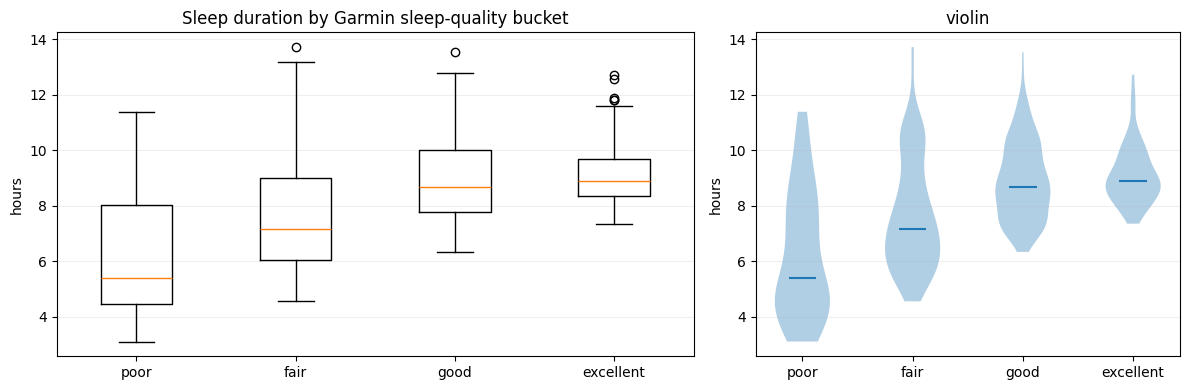

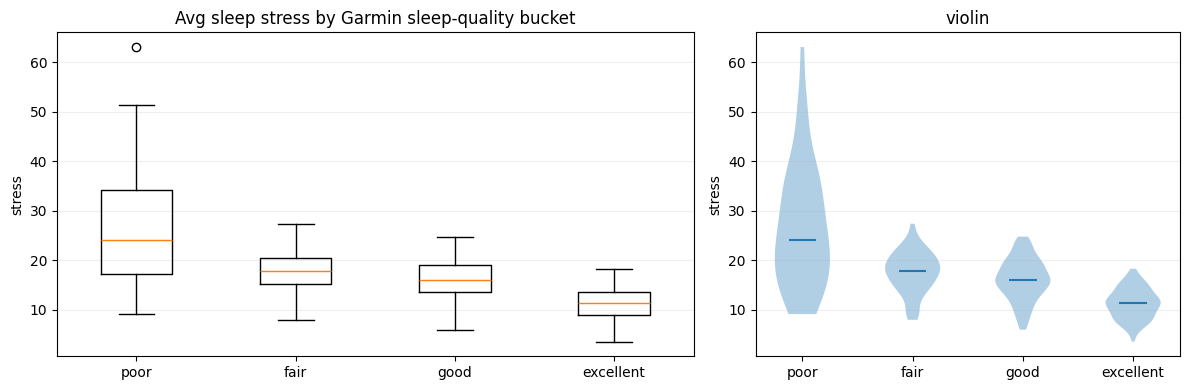

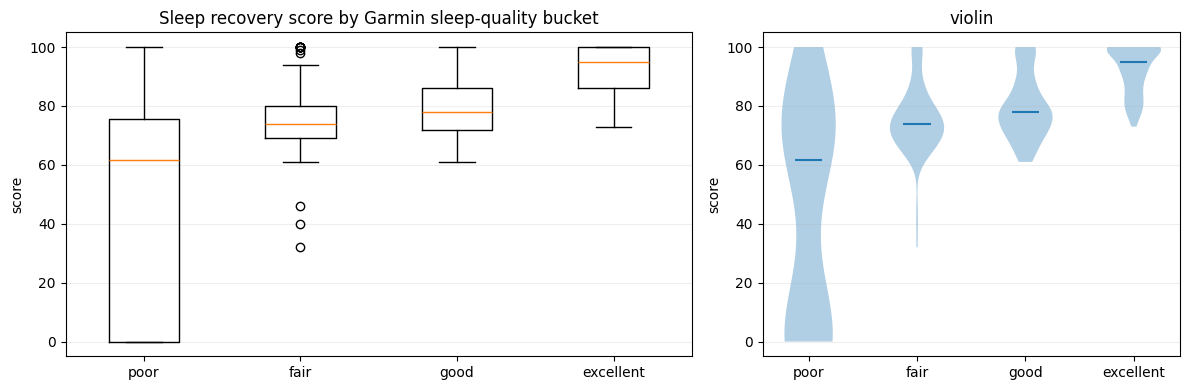

In [14]:
sleep_bucket_order = ['poor', 'fair', 'good', 'excellent']

try:
    from IPython.display import display as _safe_display
except Exception:
    def _safe_display(obj):
        print(obj.to_string(index=False) if hasattr(obj, 'to_string') else obj)

if 'sleep_quality_bucket_garmin' not in df_sleep_d.columns:
    print('Skip: missing sleep_quality_bucket_garmin')
else:
    bucket_counts = (
        df_sleep_d['sleep_quality_bucket_garmin']
        .astype(str)
        .value_counts()
        .rename_axis('bucket')
        .reset_index(name='rows')
    )
    _safe_display(bucket_counts)

    sleep_bucket_specs = [
        ('sleep_total_hours', 'Sleep duration by Garmin sleep-quality bucket', 'hours', 'seg_sleep_bucket_sleep_hours_box'),
        ('avgSleepStress', 'Avg sleep stress by Garmin sleep-quality bucket', 'stress', 'seg_sleep_bucket_avg_sleep_stress_box'),
        ('sleepRecoveryScore', 'Sleep recovery score by Garmin sleep-quality bucket', 'score', 'seg_sleep_bucket_recovery_score_box'),
    ]
    for col, title, ylabel, fig_name in sleep_bucket_specs:
        plot_segmented_box(
            df_sleep_d,
            col,
            segment_col='sleep_quality_bucket_garmin',
            order=sleep_bucket_order,
            title=title,
            ylabel=ylabel,
            fig_name=fig_name,
        )


### Segmented distribution findings (finalized)

- Day-of-week segmentation adds signal that weekday/weekend split misses.
- **Saturday** is the most active day in this view: `active_hours` median ≈1.35h and `totalSteps` median ≈8079, both above the weekday baseline.
- **Sunday** is the clearest low-activity day: `active_hours` median ≈0.50h and `totalSteps` median ≈2822.
- **Tuesday** has the highest median awake stress (`allDayStress_AWAKE_averageStressLevel` median ≈58), consistent with the user’s domain context and useful as a hypothesis anchor for Block E checks.
- Sleep duration by **sleep-onset weekday** follows a plausible weekly rhythm: it is shortest for `Mon` onset (median ≈7.88h) and longest for `Sat` onset (median ≈8.9h).
- Weekday vs weekend sleep-onset anchored split is directionally consistent: weekends show slightly longer sleep (`sleep_total_hours` median ≈8.85 vs 8.4) and lower `avgSleepStress` (≈14.72 vs 15.84).
- Garmin sleep-quality buckets form a coherent gradient:
  - median `sleep_total_hours`: poor≈5.4h, fair≈7.17h, good≈8.68h, excellent≈8.9h
  - median `avgSleepStress`: poor≈24.16, fair≈17.82, good≈16.09, excellent≈11.37
- One `unknown` bucket row remains as an edge case and is excluded from interpretation-heavy conclusions.

These segmented results are stable enough to treat Block D (distributions + segmentation) as complete; directional relationship testing continues in `04_eda_relationships.ipynb`.


## 4. Handoff to Stage 2.3

- Distribution and segmentation baselines are now fixed in this notebook.
- Next-step causal-directional exploration is isolated in `notebooks/04_eda_relationships.ipynb` to keep this notebook focused and concise.
